In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product # grid plots
import scipy.optimize as opt # solve qp

In [44]:
def plot_linear_classifier(xmin, xmax, ymin, ymax,w,ax,b=0, color='black',margin=False):
    # generate a grid of points to evaluate classifier
    npoints = 100
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    zz = X*w[0] + Y*w[1] + b
    ax.contour(X, Y, zz, [0], colors=color)
    if margin:
      ax.contour(X, Y, zz, [-1,1], linestyles='dashed', colors=color)
    return ax.contourf(X, Y, zz, 20, cmap='PuOr', alpha=0.2)


def plot_linear_classifier_boundary(xmin, xmax, ymin, ymax,w,ax,b=0, 
                                    color='black'):
    # generate a grid of points to evaluate classifier
    npoints = 100
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    zz = X*w[0] + Y*w[1] + b
    return ax.contour(X, Y, zz, [0], colors=color)
    
     

def plot_support_vectors(x,y,w,b,ax):
    # generate a grid of points to evaluate classifier
    functional_margin = y * (x.dot(w) + b) # this quantity is 1 for the SVs
    id_svs = np.where(np.absolute(functional_margin-1) < 1e-3) # some tolerance
    return ax.scatter(x[id_svs,0], x[id_svs,1],marker='d', color='black', label='SVs')

def plot_radius_angle_classifier(xmin, xmax, ymin, ymax,w,ax,b=0, color='black',margin=False):
    # generate a grid of points to evaluate classifier
    npoints = 200
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    r = np.sqrt(X**2 + Y**2)
    phi = np.arctan(Y/X)
    zz = r*w[0] + phi*w[1] + b
    ax.contour(X, Y, zz, [0.], colors=color)
    if margin:
      ax.contour(X, Y, zz, [-1,1], linestyles='dashed', colors=color)
    return ax.contourf(X, Y, zz, 25, cmap='PuOr', alpha=0.2)

def plot_radius_angle_support_vectors(xx,y,w,b,ax):
    # generate a grid of points to evaluate classifier
    x = np.empty(xx.shape)
    x[:,0] = np.sqrt(np.sum(xx**2,1))
    print(x)
    x[:,1] = np.arctan(xx[:,1]/xx[:,0])
    functional_margin = y * (x.dot(w) + b) # this quantity is 1 for the SVs
    print(functional_margin)
    id_svs = np.where(np.absolute(functional_margin-1) < 1e-3) # some tolerance
    print(id_svs)
    return ax.scatter(xx[id_svs,0], xx[id_svs,1],marker='d', color='black', label='SVs')

def xp_yp(x,y,a,b):
  ap = -1./a
  bp =  y + x/a
  xp = (b - bp)/(ap-a)
  yp = a*xp + b
  return xp, yp 

def wb_from_ab(a, b):
  if a < 0:
    return np.array([-a, 1]), -b
  return np.array([a, -1]), b

def ab_from_xy(x,y):
  X = np.ones((2,2))
  X[0,0] = x[0]
  X[1,0] = x[1]
  w = np.linalg.solve(X,y)
  return w[0], w[1]
def get_geometrical_margin(x,y,w,b=0):
    functional_margin = y * (x.dot(w) + b)
    normalized_margin = functional_margin / np.linalg.norm(w)
    closest_sample = np.argmin(normalized_margin)
    margin = normalized_margin[closest_sample]
    return margin, closest_sample

# Máquinas de Vectores Soporte

### Aprendizaje Automático Intermedio e Ingeniería de Características

#### Febrero 2021

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />


Las [Máquinas de Vectores Soporte (SVMs)](http://scikit-learn.org/stable/modules/svm.html) son una familia de modelos de aprendizaje supervisado que pueden emplearse para resolver problemas de clasificación y de regresión. 

En esta sesión desarrollaremos intuiciones acerca del funcionamiento de las SVM en problemas de clasificación e introduciremos los llamados *kernel methods* que es una de las teorías matemáticas que respaldan su funcionamiento.

## Un poco de perspectiva histórica

- El trabajo original que propone las SVM (Boser et al. 1992) trata sobre clasificación con **máximo margen**, en 1992.

- Entre finales de los 90 y principios de los 2000s las SVMs se convirtieron en un *standard de facto* en algoritmos de clasificación automática, hasta que fueron desplazadas del foco por las Redes Neuronales Profundas (Deep Learning Neural Nets)

- Las SVM son el ejemplo más representativo de una tecnología de aprendizaje automático denominada **métodos kernel**, que significaron una pequeña revolución dentro de la comunidad científica del aprendizaje automático en aquellos días. Las Redes Neuronales estaban un poco de capa caída debido a que el impacto científico en número de publicaciones y volumen de investigación no se había traducido en casi ninguna aplicación industrial, así que en aquellos momentos el aprendizaje automático era considerado más bien un campo para la investigación académica. 

- Los **métodos kernel** se aportan matemáticas robustas, como por ejemplo un problema de optimización claramente expresado que converge a un **óptimo global**, y una manera bastante robusta e inmediata de  desarrollar **versiones no lineales** de modelos lineales ampliamente empleados.

- Las principales *keywords* de SVM son: **margen**, **programación cuadrática**, **dispersión**,  **truco del kernel**, **hinge loss**, **regularización**.

----

Boser, B., Guyon, I. and Vapnik, V., A training algorithm for optimal margin classifiers, In COLT '92: Proceedings of the fifth annual workshop on Computational learning theory, July 1992

# Repaso de conceptos de matemáticas que usaremos en la sesión

En esta sesión vamos a usar dos herramientas matemáticas más o menos técnicas:
- Optimización de una función con restricciones mediante multiplicadores de Lagrange
- Cálculo de la distancia de un punto a un plano (en un espacio de cualquier dimensionalidad)

## Optimización con restricciones

Supongamos que necesitamos minimizar una función $f(\mathbf x)$ donde la variable independiente es un vector $\mathbf x$. El procedimiento habitual es calcular el **gradiente**  (derivada aplicada a vectores) de la función con respecto a $\mathbf x$ e igualar a cero el resultado y obtener la posición del mínimo de la ecuación resultante.
$$
\min_{\mathbf x} f(\mathbf x) \rightarrow \nabla_{\mathbf x} f(\mathbf x) = \mathbf 0
$$

En un caso sencillo en dos dimensiones:

[-0.33333333 -0.33333333]


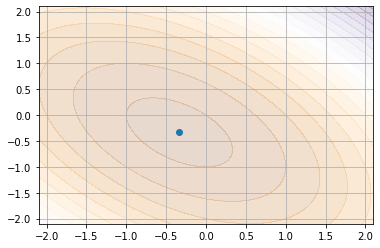

In [54]:
npoints = 100
xmin = -2
xmax=2
ymin=-2
ymax=2
Xg = np.linspace(xmin-.05*np.absolute(xmin),
               xmax + .05*np.absolute(xmax),
               npoints) # or whatever values for x
Yg = np.linspace(ymin-.05*np.absolute(ymin),
               ymax + .05*np.absolute(ymax),
               npoints)   # or whatever values for y
X, Y = np.meshgrid(Xg, Yg)

Xshape = X.shape
XX = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
M = np.array([[1., 0.5],[0.5,1.]])

zz = np.sum(XX.dot(M)*XX,1) + XX.dot(np.ones(2)) + 2
zz = zz.reshape(Xshape)
_=plt.contourf(X, Y, zz, 20, cmap='PuOr', alpha=0.2)

plt.grid()

solucion = -0.5*np.linalg.inv(M).dot(np.ones(2))
print(solucion)
plt.scatter(solucion[0],solucion[1])

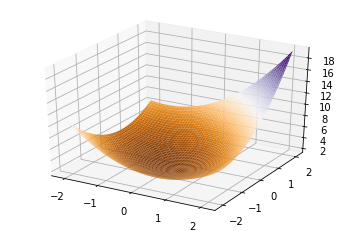

In [50]:
from mpl_toolkits.mplot3d import Axes3D  
fig ,ax = plt.subplots(subplot_kw={"projection": "3d"})
_=ax.plot_surface(X, Y, zz, cmap='PuOr')

Optimización con restricciones significa que ya no buscamos el mínimo global de esa función, sino un mínimo dentro de un subconjunto de $\mathbf x$ definido mediante las restricciones:
$$
\min_{\mathbf x} f(\mathbf x) 
$$
$$
\mbox{sujeto a } g(\mathbf x) = c
$$

Por ejemplo en el caso anterior podemos introducir una restricción lineal, es decir, que $\mathbf x$ esté dentro de una línea, marcada en negro en la figura.


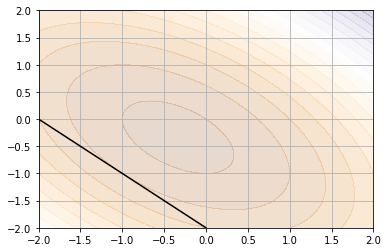

In [60]:
plt.figure()
plt.plot([-2, 0],[0,-2],color='black')
_=plt.contourf(X, Y, zz, 20, cmap='PuOr', alpha=0.2)
plt.xlim((-2,2))
plt.ylim((-2,2))

plt.grid()


Si añadimos la restricción el mínimo global ya no nos sirve porque no cumple con la restricción (no está dentro de la recta negra).

La manera de encontrar el mínimo es mediante un multiplicador de Lagrange, $\alpha$
$$
\min_{\mathbf x} \max_{\alpha} f(\mathbf x) + \alpha(c-g(\mathbf x))
$$

Ahora el funcional tiene dos variables, $\mathbf x$ y $\alpha$. Para resolver podemos plantear el sistema de ecuaciones resultante de optimizar con respecto a las dos variables:
$$
\left \{ \begin{array}{lcl} \nabla_{\mathbf x} f(\mathbf x) -\alpha \nabla_{\mathbf x}g(\mathbf x) &=& \mathbf 0 \\ c-g(\mathbf x) &=& 0\end{array} \right.
$$

En el caso que estamos estudiando

[-1. -1.]


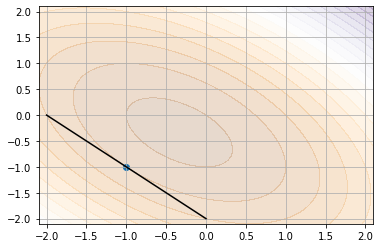

In [62]:
_=plt.contourf(X, Y, zz, 20, cmap='PuOr', alpha=0.2)
plt.plot([-2, 0],[0,-2],color='black')
plt.grid()

solucion = -np.ones(2)
print(solucion)
plt.scatter(solucion[0],solucion[1])

## Cálculo de la distancia de un punto a un plano

Un (hiper)plano en un espacio de $M$ dimensiones viene definido por un vector $\mathbf w \in \mathbb R^M$ y una constante $w_0$. Los puntos de $\mathbb R^M$ que **pertenecen** al plano verifican la ecuación

$$
\mathbf w^\top \mathbf x + w_0 =0
$$

Definimos la distancia a ese plano de un punto $\mathbf z$ que **no pertenece** al plano, a la distancia entre $\mathbf z$ y el punto del plano que sea más cercano.

En un ejemplo en dos dimensiones

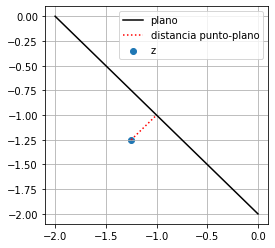

In [69]:
plt.figure(figsize=(4,4))
plt.plot([-2, 0],[0,-2],color='black',label='plano')
plt.grid()
plt.scatter(-1.25,-1.25,label='z')
plt.plot([-1.25,-1],[-1.25,-1],color='red',label='distancia punto-plano',linestyle=':')
plt.legend()

Podemos aprovechar la optimización con restricciones para calcular la distancia entre $\mathbf z$ y el plano definido mediante $\mathbf w$ y $w_0$. Para ello buscaremos el punto del plano $\mathbf x$ que esté más cerca de $\mathbf z$.

La distancia entre $\mathbf x$ y $\mathbf z$ será

$$
\sqrt{(\mathbf x - \mathbf z)^\top(\mathbf x - \mathbf z)}
$$

Luego el punto más cercano del plano será la solución del problema
$$
\min_{\mathbf x} (\mathbf x - \mathbf z)^\top(\mathbf x - \mathbf z)
$$
$$
\mbox{sujeto a } \mathbf w^\top \mathbf x + w_0 =0
$$

Introduciendo la restricción con multiplicador de Lagrange $\alpha$:
$$
\min_{\mathbf x} \max_{\alpha} \frac{1}{2} (\mathbf x - \mathbf z)^\top(\mathbf x - \mathbf z) + \alpha(\mathbf w^\top \mathbf x + w_0)
$$

Gradiente con respecto a $\mathbf x$
$$
\mathbf x - \mathbf z + \alpha \mathbf w = \mathbf 0
$$

Despejando 

$$
\mathbf x - \mathbf z = - \alpha \mathbf w 
$$

Luego la distancia entre $\mathbf x$ y $\mathbf z$ puede calcularse como

$$
\sqrt{(\mathbf x - \mathbf z)^\top(\mathbf x - \mathbf z)} = \alpha \|\mathbf w\|
$$

Es decir, que la distancia entre el punto exterior y el plano **es proporcional a la norma del vector que define el plano**.

# 1. Motivación de la SVM

## Clasificación Automática

**Clasificación Automática**: encontrar una función $f(\mathbf x)$ tal que su salida sea la clase correcta a la que pertenece la observación $\mathbf x$. Las clases son finitas y conocidas de antemano (forman parte de la definición del problema).

Nuestro objetivo es encontrar algoritmos que aprendan la mejor $f()$ posible a partir de un conjunto de **observaciones etiquetadas correctamente** (es decir, sabemos la **clase correcta** a la que pertenece cada una de las observaciones que hay en el conjunto de entrenamiento).



<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

## De clasificadores de umbral a clasificadores lineales

Quizá el problema de clasificación más sencillo que podamos imaginar sea un problema de clasificación **binaria**, **separable**, donde las observaciones $x$ poseen una única característica (o dimensión, 1D). 

Problemas de este tipo pueden resolverse fácilmente empleando **clasificadores de umbral**

$$
f_{\mbox{stump}}(x) = \left \{ \begin{array}{ll} \mbox{True} & \mbox{if } x \le u \\  \mbox{False} & \mbox{if } x > u \end{array} \right.
$$


<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

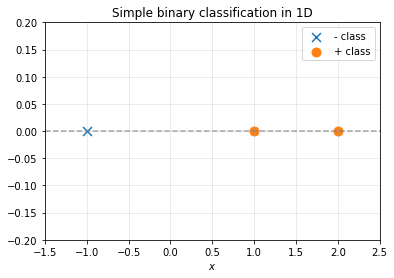

In [3]:
x = np.array([-1, 1,2])
y = np.array([-1,1,1])
plt.figure()
plt.plot([-1.5,2.5],[0, 0],color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axis([-1.5,2.5,-0.2,0.2])
plt.scatter([x[0]], [0], marker='x', s=80, label='- class' )
plt.scatter(x[y==1], np.zeros(2), marker='o', s=80, label='+ class' )
plt.grid(alpha=0.3)

plt.xlabel('$x$')
plt.title('Simple binary classification in 1D')
_=plt.legend()


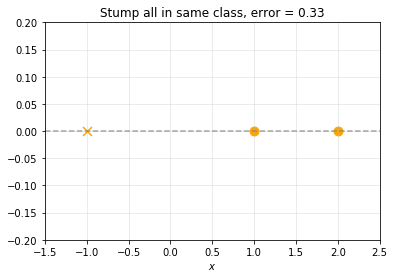

In [4]:
x = np.array([-1, 1,2])
y = np.array([-1,1,1])
plt.figure()
plt.plot([-1.5,2.5],[0, 0],color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axis([-1.5,2.5,-0.2,0.2])
plt.scatter([x[0]], [0], marker='x', s=80, label='- class', color='orange' )
plt.scatter(x[y==1], np.zeros(2), marker='o', s=80, label='+ class', color='orange' )
plt.grid(alpha=0.3)
#plt.plot([0,0],[-0.1, 0.1],color='black', label='stump classifier', linewidth=2)

plt.xlabel('$x$')
plt.title('Stump all in same class, error = 0.33')
#_=plt.legend()
plt.savefig('stump2.png')

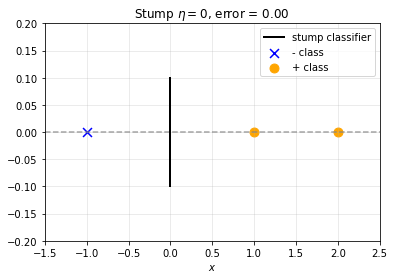

In [5]:
x = np.array([-1, 1,2])
y = np.array([-1,1,1])
plt.figure()
plt.plot([-1.5,2.5],[0, 0],color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axis([-1.5,2.5,-0.2,0.2])
plt.scatter([x[0]], [0], marker='x', s=80, label='- class', color='blue' )
plt.scatter(x[y==1], np.zeros(2), marker='o', s=80, label='+ class', color='orange' )
plt.grid(alpha=0.3)
plt.plot([0,0],[-0.1, 0.1],color='black', label='stump classifier', linewidth=2)

plt.xlabel('$x$')
plt.title('Stump $\eta=0$, error = 0.00')
_=plt.legend()
plt.savefig('stump3.png')

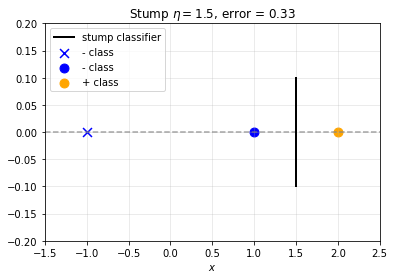

In [6]:
x = np.array([-1, 1,2])
y = np.array([-1,1,1])
plt.figure()
plt.plot([-1.5,2.5],[0, 0],color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axis([-1.5,2.5,-0.2,0.2])
plt.scatter([x[0]], [0], marker='x', s=80, label='- class', color='blue' )
plt.scatter([x[1]], [0], marker='o', s=80, label='- class', color='blue' )
plt.scatter(x[2], [0], marker='o', s=80, label='+ class', color='orange' )
plt.grid(alpha=0.3)
plt.plot([1.5,1.5],[-0.1, 0.1],color='black', label='stump classifier', linewidth=2)

plt.xlabel('$x$')
plt.title('Stump $\eta=1.5$, error = 0.33')
_=plt.legend()
plt.savefig('stump4.png')

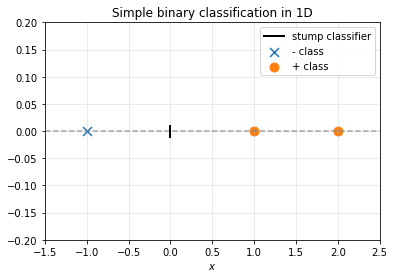

In [7]:
x = np.array([-1, 1,2])
y = np.array([-1,1,1])
plt.figure()
plt.plot([-1.5,2.5],[0, 0],color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axis([-1.5,2.5,-0.2,0.2])
plt.scatter([x[0]], [0], marker='x', s=80, label='- class' )
plt.scatter(x[y==1], np.zeros(2), marker='o', s=80, label='+ class' )
plt.grid(alpha=0.3)
plt.plot([0,0],[-0.01, 0.01],color='black', label='stump classifier', linewidth=2)

plt.xlabel('$x$')
plt.title('Simple binary classification in 1D')
_=plt.legend()

 Los clasificadores de umbral pueden **generalizarse a problemas binarios separables en más de 1D** mediante clasificadores lineales.

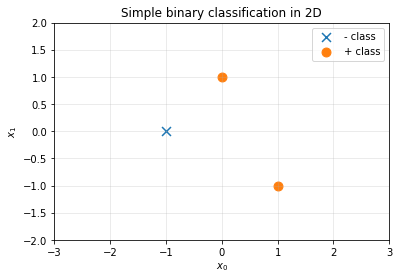

In [8]:
x2D = np.array([[-1,0], [0,1], [1,-1]])
y = np.array([-1,1,1])
plt.figure()

plt.scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='- class' )
plt.scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='+ class' )
plt.grid(alpha=0.3)
#plt.plot([0,0],[-0.01, 0.01],color='black', label='stump classifier', linewidth=2)

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Simple binary classification in 2D')
plt.axis([-3,3,-2,2])
_=plt.legend()

El término **clasificadores lineales** quiere decir que esperamos encontrar una función de clasificación

$$
f(\mathbf x) = \mbox{sign}\left\{\mathbf w^\top \mathbf x + b \right\}= \mbox{sign}\left\{w_0x_0 + w_1x_1 + b \right\}
$$ donde $w_0, w_1$ y $b$ son los parámetros libres del modelo. 

Existen infinitos juegos de valores para $w_0, w_1$ y $b$ que resuelven el problema con 0 erroes de clasificación. Por ejmplo, estos 3 planos de la figura

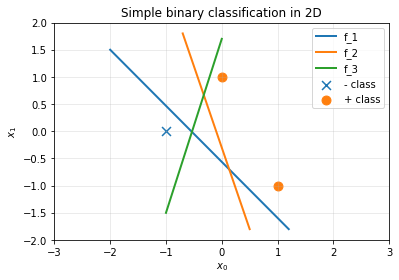

In [9]:
x2D = np.array([[-1,0], [0,1], [1,-1]])
y = np.array([-1,1,1])
plt.figure()

plt.scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='- class' )
plt.scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='+ class' )
plt.grid(alpha=0.3)

plt.plot([-2,1.2],[1.5, -1.8], label='f_1', linewidth=2)
plt.plot([-0.7,0.5],[1.8, -1.8], label='f_2', linewidth=2)
plt.plot([-1,0],[-1.5, 1.7], label='f_3', linewidth=2)

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Simple binary classification in 2D')
plt.axis([-3,3,-2,2])
_=plt.legend()

## Minimización del Riesgo Estructural

Todos los infinitas soluciones de este problema separable no son **cualitativamente** iguales. Si bien respecto de clasificar correctamente el conjunto de entrenamiento no presentan diferencia, sí que aparecen diferencias cualitativas si pensamos en que van a tener que clasificar correctamente las muestras de test que se presenten en el futuro.

Vamos a esbozar cuál serían los comportamientos de estos 3 clasificadores lineales que tienen 0 errores en el conjunto de entrenamiento con muestras de test.

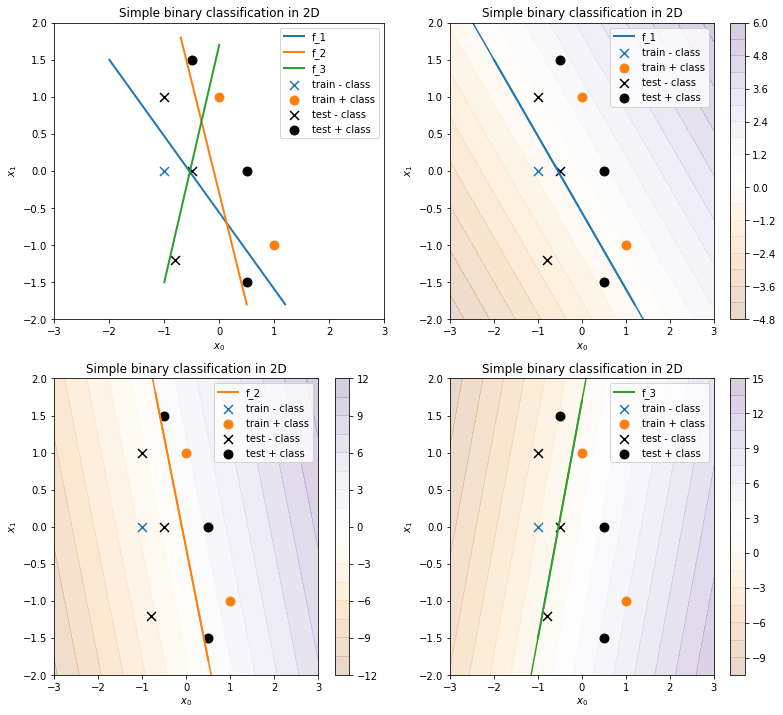

In [10]:
XF = np.array([[-2, 1.2], [-0.7,0.5], [-1,0]])
YF = np.array([[1.5, -1.8], [1.8, -1.8],[-1.5, 1.7]])

x2D = np.array([[-1,0], [0,1], [1,-1]])
y = np.array([-1,1,1])

xtest = np.array([[-0.8, -1.2], [-1,1], [-0.5, 0], [0.5, -1.5], [-0.5, 1.5], [0.5,0] ])
ytest = np.array([-1, -1, -1, 1, 1, 1])

xall = np.vstack((x2D, xtest))
yall = np.hstack((y, ytest))

ff,aa = plt.subplots(2,2, figsize=(13,12))
xmin = -3
xmax = 3
ymin = -2
ymax = 2

for ii, ax, lab in zip(range(XF.shape[0]), [aa[0][1], aa[1][0], aa[1][1]], ['f_1', 'f_2','f_3']):
  aa[0][0].plot(XF[ii,:],YF[ii,:], label=lab, linewidth=2)
  color = aa[0][0].lines[-1].get_color()
  ax.plot(XF[ii,:],YF[ii,:], label=lab, linewidth=2, color=color)
  a, bb = ab_from_xy(XF[ii,:],YF[ii,:])
  w, b = wb_from_ab(a, bb)
  cs = plot_linear_classifier(xmin, xmax, ymin, ymax,w,ax,b, color)
  ff.colorbar(cs, ax=ax)
for ii in range(2):
  for jj in range(2):
    aa[ii][jj].scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
    aa[ii][jj].scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )
    aa[ii][jj].scatter(xtest[ytest==-1,0], xtest[ytest==-1,1], marker='x', s=80, label='test - class', color='black' )
    aa[ii][jj].scatter(xtest[ytest==1,0], xtest[ytest==1,1], marker='o', s=80, label='test + class', color='black' )
    #aa[ii][jj].grid(alpha=0.3)

    aa[ii][jj].set_xlabel('$x_0$')
    aa[ii][jj].set_ylabel('$x_1$')
    aa[ii][jj].set_title('Simple binary classification in 2D')
    aa[ii][jj].axis([xmin, xmax, ymin, ymax])
    _=aa[ii][jj].legend()

El acierto de los 3 clasificadores con los datos de test es diverso:
- $f_1$ presenta 3 aciertos y 3 fallos en los datos de test
- $f_2$ presenta 6 aciertos y 0 fallos en los datos de test
- $f_3$ presenta 3 aciertos y 3 fallos en los datos de test

Vamos a intentar analizar por qué $f_2$ tiene mejor comportamiento que los otros dos clasificadores.

## Clasificadores de máximo margen

La **Minimización del Riesgo Estructural** aconseja usar como clasificador al que maximice la distancia entre la **frontera de clasificación** (donde residen las clasificaciones dudosas) y las observaciones del conjunto de entrenamiento. Esta distancia entre observaciones y frontera de clasificación se conoce como  **margen**.



### Definición de margen


- El **margen funcional** (curvas de nivel en las gráficas anteriores) de cada observación $\mathbf x_i$ con etiqueta verdadera $y_i$, es la cantidad $ y_i(\mathbf{w}^{\top}\mathbf x_i + b)$. En un problema separable el margen funcional debería ser positivo para todas las observaciones de entrenamiento. Que todos los márgenes funcionales sean positivos es una **restricción** a imponer en el diseño del clasificador. 

- El **margen geométrico** del clasificador es la distancia entre la frontera de clasificación  la observación más cercana. Puede calcularse como 
$$ \frac{y_*(\mathbf{w}^{\top}\mathbf x_* + b)}{|\mathbf w|}$$  
donde $\mathbf x_*$ es la observación más cercana a la frontera de clasificación e $y_*$ es su clase verdadera.


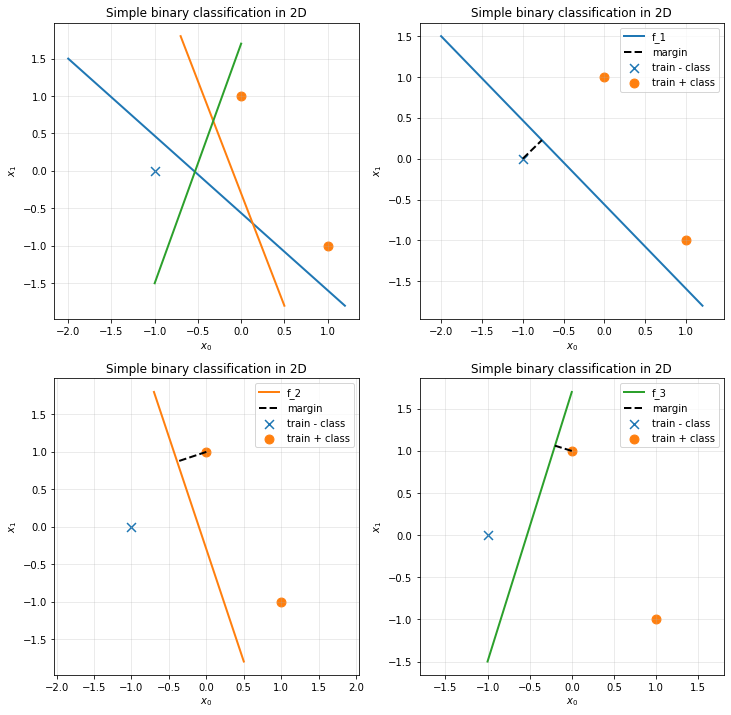

In [11]:


x2D = np.array([[-1,0], [0,1], [1,-1]])
y = np.array([-1,1,1])


ff,aa = plt.subplots(2,2, figsize=(12,12))


aa[0][0].plot(XF[0,:],YF[0,:], label='f_1', linewidth=2)
aa[0][1].plot(XF[0,:],YF[0,:], label='f_1', linewidth=2, color=aa[0][0].lines[-1].get_color())
aa[0][0].plot(XF[1,:],YF[1,:],label='f_2', linewidth=2)
aa[1][0].plot(XF[1,:],YF[1,:], label='f_2', linewidth=2, color=aa[0][0].lines[-1].get_color())
aa[0][0].plot(XF[2,:],YF[2,:], label='f_3', linewidth=2)
aa[1][1].plot(XF[2,:],YF[2,:], label='f_3', linewidth=2, color=aa[0][0].lines[-1].get_color())



for ii in range(2):
  for jj in range(2):
    aa[ii][jj].scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
    aa[ii][jj].scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )
    aa[ii][jj].grid(alpha=0.3)

    aa[ii][jj].set_xlabel('$x_0$')
    aa[ii][jj].set_ylabel('$x_1$')
    aa[ii][jj].set_title('Simple binary classification in 2D')
projection_on_boundary = {}
closest_sample = {}
for ii in range(XF.shape[0]):
  a, bb = ab_from_xy(XF[ii,:],YF[ii,:])
  w, b = wb_from_ab(a, bb)
  margin, closest_sample[ii] = get_geometrical_margin(x2D, y, w, b)  
  wp = np.array([w[1], -w[0]]) 
  projection_on_boundary[ii] = xp_yp(x2D[closest_sample[ii],0],
                                     x2D[closest_sample[ii],1],
                                     a,
                                     bb) 

for ii, ax in zip(range(XF.shape[0]), [aa[0][1], aa[1][0], aa[1][1]]):
  ax.plot(np.array([x2D[closest_sample[ii],0], projection_on_boundary[ii][0]]),
         np.array([x2D[closest_sample[ii],1], projection_on_boundary[ii][1]]),
       linestyle='--',
       color='black', label='margin', linewidth=2)
  
  ax.axis([-3,3,-2,2])
  ax.axis('equal')
  _=ax.legend()
  _=ax.legend()

El margen parece un buen **heurístico** para elegir ese mejor clasificador. Ahora sólo necesitamos un **criterio matemático** para encargarle a un optimizador que, dado un conjunto de datos etiquetados, nos encuentre el clasificador lineal de máximo margen.

# 2. Clasificador de máximo margen, caso separable

Aplicando un poco de geometría podemos recordar que la anchura del margen es proporcional a $\frac{1}{|\mathbf w|}$, por tanto, la minimización de  $|\mathbf w|$ implica la maximización del margen.

Si fijamos el valor del **margen funcional** a 1, la optimización que conduce al clasificador de máximo margen es:
$$ \min_{\mathbf w} \frac{1}{2}\|\mathbf w\|^2 $$
$$ \mbox{sujeto a } y_i (\mathbf w^\top \mathbf x_i + b) \ge 1,\qquad i=1,\dots,n \qquad \qquad\mbox{(1)}$$  

Para resolver un problema de optimización con restricciones acudimos a los Multiplicadores de Lagrange $\alpha_i$ para introducir las restricciones en el funcional

$$ \min_{\mathbf w,b} \max_{\alpha_i} \frac{1}{2}\|\mathbf w\|^2 - \sum_{i=1}^n{\alpha_i \left ( y_i (\mathbf w^\top \mathbf x_i + b) -1 \right )} \qquad \qquad\mbox{(2)}$$ 
$$\mbox{con } \alpha_i \ge 0 \qquad i=1,\dots,n$$

Desarrollando la suma:

$$ \min_{\mathbf w,b} \max_{\alpha_i} \frac{1}{2}\|\mathbf w\|^2 - \sum_{i=1}^n{\alpha_i  y_i \mathbf w^\top \mathbf x_i} -   \sum_{i=1}^n{\alpha_i  y_i b} + \sum_{i=1}^n{\alpha_i}$$ 
$$\mbox{con } \alpha_i \ge 0 \qquad i=1,\dots,n$$

Ahora mismo esta optimización depende de 3 grupos de variables: $\mathbf w$, $b$ y los multiplicadores $\{\alpha_i\}_{i=1}^n$. Vamos a realizar una serie de transformaciones que nos reduzcan el problema a un único grupo de variables.

## Eliminar la dependencia con respecto a $\mathbf w$ 

Calculando  gradientes con respecto a $\mathbf w$ e igualando a $\mathbf 0$

$$\mathbf w - \sum_{i=1}^n{\alpha_i  y_i  \mathbf x_i} = \mathbf 0 \Rightarrow \mathbf w=\sum_{i=1}^n{\alpha_i  y_i  \mathbf x_i} \qquad \qquad\mbox{(3)}$$

Por tanto el vector de pesos es una **combinación lineal de las observaciones del conjunto de entrenamiento** $\mathbf w = \sum_{i=1}^n{ \alpha_iy_i\mathbf x_i}$

Si llevamos este resultado (sustituir los $\mathbf w$ por la combinación lineal de observaciones de entrada) la optimización se transforma en:

$$ \min_{b} \max_{\alpha_i} \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\mathbf x_i^\top \mathbf x_j - \sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\mathbf x_i^\top \mathbf x_j -   \sum_{i=1}^n{\alpha_i  y_i b} + \sum_{i=1}^n{\alpha_i}$$ 
$$
 = \min_{b} \max_{\alpha_i} -\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\mathbf x_i^\top \mathbf x_j  -   \sum_{i=1}^n{\alpha_i  y_i b} + \sum_{i=1}^n{\alpha_i} \qquad \qquad\mbox{(4)}
$$
$$\mbox{con } \alpha_i \ge 0 \qquad i=1,\dots,n$$

## Eliminar la dependencia con respecto a $b$

Optimizando (4) con respecto a $b$ 
$$\sum_{i=1}^n{\alpha_iy_i}=0 \qquad \qquad\mbox{(5)}$$

Sustituyendo (5) en la optimización principal eliminamos la dependencia con $b$

$$
 \max_{\alpha_i} -\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\mathbf x_i^\top \mathbf x_j  + \sum_{i=1}^n{\alpha_i} \qquad \qquad\mbox{(6)}
$$
$$\mbox{con } \alpha_i \ge 0 \qquad i=1,\dots,n$$
$$\mbox{sujeto a }\sum_{i=1}^n{\alpha_iy_i}=0$$

Es habitual cambiar la maximización por una minimización

$$
 \min_{\alpha_i} \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\mathbf x_i^\top \mathbf x_j  - \sum_{i=1}^n{\alpha_i} \qquad \qquad\mbox{(6)}
$$
$$\mbox{con } \alpha_i \ge 0 \qquad i=1,\dots,n$$
$$\mbox{sujeto a }\sum_{i=1}^n{\alpha_iy_i}=0$$






## Solución

La optimización resultante depende solo de los multiplicadores $\alpha_i$. Necesitamos encontrar un optimizador que nos encuentre el valor óptimo de los $\alpha_i$ (en el siguiente apartado). Una vez que sepamos la solución $\alpha_i^*$, tenemos que recorrer el camino inverso de las simplificaciones anteriores para recuperar $b^*$ y $\mathbf w^*$:

- Obtenemos $\mathbf w$ de (3): $$\mathbf w^*=\sum_{i=1}^n{\alpha_i^*  y_i  \mathbf x_i}$$
- Obtenemos $b^*$ de cualquier restricción (1) para la que se verifique que el correspondiente Multiplicador de Lagrange $\alpha_i>0$ dado que $y_i (\mathbf w^\top \mathbf x_i + b) = 1$ para esa restricción. Esto se apoya en algunos resultados matemáticos de la Teoría de Optimización con Multiplicadores de Lagrange:
 - para todas y cada una de las restricciones (1), o bien $\alpha_i=0$ o bien $y_i (\mathbf w^\top \mathbf x_i + b) = 0$, 
 - al menos dos $\alpha_i$ deben ser positivos (mayores que cero), uno por cada clase, para que la restricción (5) se cumpla
 - De hecho algún $\alpha_i$ debe ser estrictamente positivo para que el vector de pesos del clasificador no sea trivial (si todos los $\alpha_i$ son nulos, el clasificador es $\mathbf w = \mathbf 0$).

Las siguientes celdas intentan dar una visión intuitiva de cómo sucede la optimización que nos encuentra la SVM. 

Partimos del problema de juguete que estábamos usando para motivar la SVM. Para este caso con 3 observaciones, la optimización tendría que encontrar valores para tres multiplicadores, $\alpha_1$, $\alpha_2$ y $\alpha_3$.

Sabemos que los multiplicadores tienen que ser positivos y debe cumplirse que 
$$
y_1\alpha_1 + y_2\alpha_2 + y_3 \alpha_3 = 0
$$

en nuestro problema $y_1=-1$, $y_2=1$, $y_3=1$ por lo que necesariamente 
$$
\alpha_1 = \alpha_2 + \alpha_3
$$

Es decir, realmente sólo tenemos dos grados de libertad para explorar el espacio de soluciones porque cuando dé valores a $\alpha_2$ y $\alpha_3$ el valor de $alpha_1$ queda determinado.

La siguiente figura representa el espacio de búsqueda para los valores de $\alpha_2$ y $\alpha_3$. Las curvas de nivel son la norma del vector de pesos $\mathbf w$ correspondiente a cada elección de $\alpha_2$ y $\alpha_3$.

Los puntos de color son 9 ejemplos de selecciones de $\alpha_2$ y $\alpha_3$

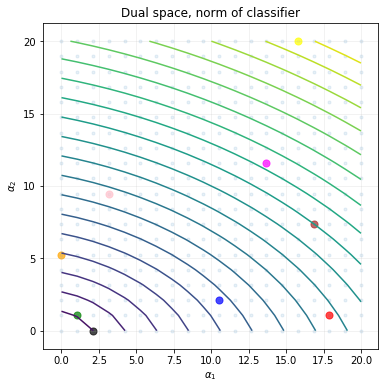

In [12]:
_=v_points = [2, 21, 37, 50, 100, 183, 156,233, 395]
mycolores = ['black','green',
             'red','blue',
             'orange','pink',
             'brown','magenta',
             'yellow','silver',
             'olive','cyan']

# 1.- generate the alphas, variables in the dual space. 
n_alfa = 20
a2min = 0
a2max=20
a3min = 0
a3max=20

# range for alpha_2
a2 = np.linspace(a2min,
                 a2max,
               n_alfa) 
# range for alpha_3
a3 = np.linspace(a3min,
               a3max,
               n_alfa) 

# grid values for alpha_2 and alpha_3
A2, A3 = np.meshgrid(a2, a3)
A2shape = A2.shape
A2 = A2.reshape(-1,1)
A3 = A3.reshape(-1,1)
A1 = A2 + A3 # in this case y1 is negative, while y2 nd y3 are positive
ALFAS = np.hstack((A1,A2,A3))

# get primal variables W (weight vector) W0 (intercept)
W = ALFAS.dot(np.diag(y).dot(x2D))

ff,ax = plt.subplots(1,1,figsize=(6,6))

zz = 0.5*np.linalg.norm(W,axis=1)
zz = zz.reshape(A2shape)
ax.contour(a2, a3, zz,20)
ax.grid(alpha=0.2)
ax.scatter(A2,A3,marker='.',alpha=0.1)

for jj,vv in enumerate(v_points):
    ax.scatter(A2[vv], A3[vv],marker='o',s=50,color=mycolores[jj],alpha=0.7)




ax.set_title('Dual space, norm of classifier')
ax.set_xlabel('$\\alpha_1$')
_=ax.set_ylabel('$\\alpha_2$')

El primer paso de la solución es reconstruir el vector de pesos $\mathbf w$:
$$
\mathbf w = -\alpha_1\mathbf x_1 + \alpha_2\mathbf x_2 + \alpha_3 \mathbf x_3 = \left [ \begin{array}{c} w_1\\w_2\end{array}\right ]
$$

La siguiente figura ilustra los vectores de pesos $\mathbf w$ que se obtendrían a partir de las elecciones de $\alpha_2$ y $\alpha_3$ de la celda anterior

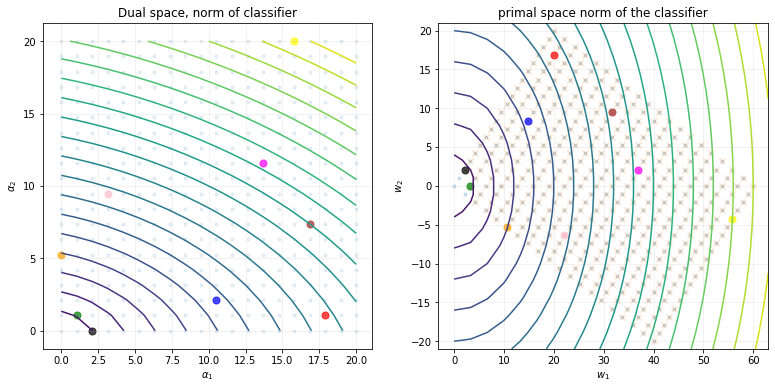

In [13]:
ff,aa = plt.subplots(1,2,figsize=(13,6))
ax=aa[0]
zz = 0.5*np.linalg.norm(W,axis=1)
zz = zz.reshape(A2shape)
ax.contour(a2, a3, zz,20)
ax.grid(alpha=0.2)
ax.scatter(A2,A3,marker='.',alpha=0.1)

for jj,vv in enumerate(v_points):
    ax.scatter(A2[vv], A3[vv],marker='o',s=50,color=mycolores[jj],alpha=0.7)




ax.set_title('Dual space, norm of classifier')
ax.set_xlabel('$\\alpha_1$')
_=ax.set_ylabel('$\\alpha_2$')

xi = np.outer(np.ones(W.shape[0]), y)-W.dot(x2D.T)
xi_lower = np.max(xi[:,1:],1)
xi_upper = xi[:,0]

id_my_w0 = xi_upper >= xi_lower

id_clf = np.where(id_my_w0)[0]
W0 = (xi_upper + xi_lower)/2


# get each classifier as y=ax + b
AA = -W[id_my_w0,1]/W[id_my_w0,0]
BB = -W0[id_my_w0]/W[id_my_w0,0]

# plot



# primal space, weights with norm
n_w = 20
ax=aa[1]
ax.scatter(W[:,0],W[:,1],marker='.',alpha=0.2)


ax.scatter(W[id_my_w0,0],W[id_my_w0,1],marker='x',alpha=0.2)

for jj,vv in enumerate(v_points):
    ax.scatter(W[vv,0],W[vv,1],marker='o',s=50,color=mycolores[jj],alpha=0.7)


wxmin = np.min(W[:,0])
wxmax= np.max(W[:,0])
wymin = np.min(W[:,1])
wymax= np.max(W[:,1])
Xg = np.linspace(wxmin-.05*np.absolute(wxmin),
               wxmax + .05*np.absolute(wxmax),
               n_w) # or whatever values for x
Yg = np.linspace(wymin-.05*np.absolute(wymin),
               wymax + .05*np.absolute(wymax),
               n_w)   # or whatever values for y
X, Y = np.meshgrid(Xg, Yg)
Xshape = X.shape
WW = np.hstack((X.reshape(-1,1),Y.reshape(-1,1)))
zz = 0.5*np.linalg.norm(WW,axis=1)
zz = zz.reshape(Xshape)
ax.contour(Xg, Yg, zz, 20)
ax.grid(alpha=0.2)
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
_=ax.set_title('primal space norm of the classifier')



El siguiente paso es obtener el término constante $w_0$ de alguna de las restricciones con multiplicador de Lagrange no nulo. En este caso sencillo los 3 multiplicadores son no nulos. 

Obteniendo $w_0$ y reescribiendo 
$$
\mathbf w^\top \mathbf x + w_0 = 0 \Rightarrow \left [ \begin{array}{cc} w_1 & w_2\end{array}\right ] \left [ \begin{array}{c} x_1 \\ x_2\end{array}\right ] + w_0 \Rightarrow x_2 = ax_1 + b
$$

podemos encontrar, para cada clasificador del espacio de búsqueda, cuáles serían sus coeficientes $a$ y $b$. La  figura de la izquierda representa estos coeficientes $a$ y $b$ para los clasificadores de las figuras anteriores.

La figura de la derecha representa los 9 clasificadores marcados con puntos de colores dentro del espacio de búsqueda como funciones $x_2 = ax_1+b$

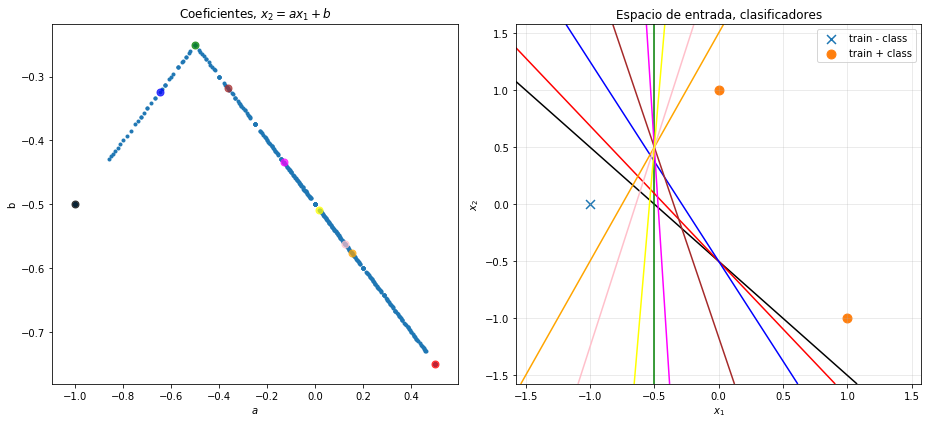

In [14]:



ff,aa = plt.subplots(1,2,figsize=(13,6))

ax = aa[0]
ax.scatter(AA,BB,marker='.')
for jj,vv in enumerate(v_points):
    ax.scatter(AA[vv], BB[vv],marker='o',s=50,color=mycolores[jj],alpha=0.7)

ax.set_title('Coeficientes, $x_2=ax_1+b$')
ax.set_xlabel('$a$')
ax.set_ylabel('b')


ax=aa[1]
ax.scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
ax.scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )
ax.grid(alpha=0.3)


for jj,myclf in enumerate(v_points):
    cs=plot_linear_classifier_boundary(-1.5, 1.5, -1.5, 1.5,
                                    W[myclf,:],ax,W0[myclf], mycolores[jj])
    
ax.legend()
ax.set_title('Espacio de entrada, clasificadores')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ff.tight_layout()

La siguiente figura representa cada uno de los 9 clasificadores individualmente para poder comprobar visualmente cuál es el margen de cada uno. En las figuras de arriba se puede comprobar la norma de cada vector de pesos correspondientes para ganar intuiciones de la relación entre margen y norma.

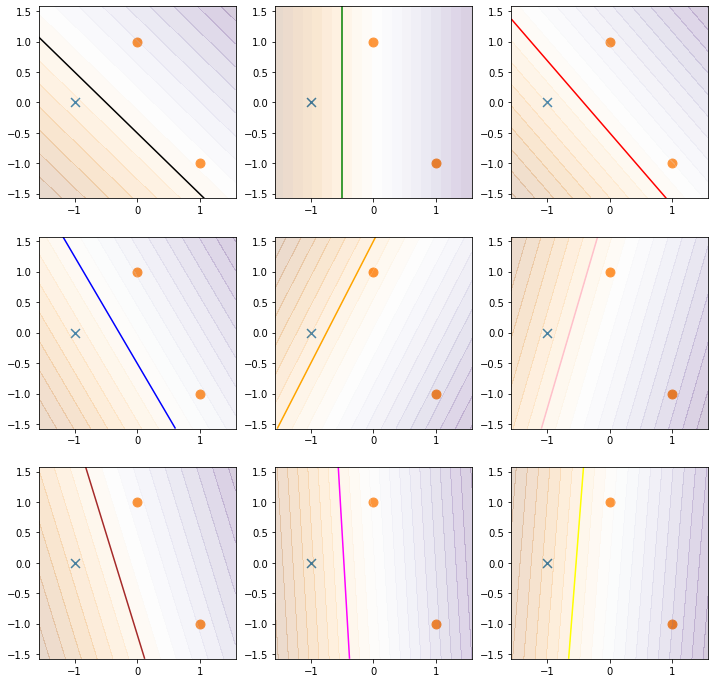

In [15]:
nrows=3
ncols=3
ff,aa = plt.subplots(nrows,ncols,figsize=(12,12))

jj=0
for rr in range(nrows):
    for cc in range(ncols):
        myclf = v_points[jj]
        aa[rr][cc].scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
        aa[rr][cc].scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )
        plot_linear_classifier(-1.5, 1.5, -1.5, 1.5,W[myclf,:]
                               ,aa[rr][cc],W0[myclf], color=mycolores[jj],margin=False)
        jj += 1

### Programación Cuadrática 

Problemas de optimización que poseen la siguiente estructura
$$ \min_{\mathbf {a}} \frac{1}{2} \mathbf a^\top P \mathbf a - \mathbf q^\top \mathbf a$$
$$\mbox{sujeto a } \mathbf h^\top\mathbf a= c$$
$$\mbox{y } G\mathbf a \preceq \mathbf 0, $$
se conocen como **Programas Cuadráticos** dado que incorporan una forma cuadrática $\mathbf a^\top P \mathbf a$ en el funcional.

Estas optimizaciones se pueden resolver en python con el módulo [cvxopt](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)

En nuestro caso, la identificación que se necesita hacer para resolver la optimización de la SVM con esta técnica es la siguiente:
- $$\mathbf a \leftarrow \boldsymbol \alpha = \left [ \begin{array}{c} \alpha_1 \\ \alpha_2 \\ \vdots \\ \alpha_n \end{array}\right ]  $$

- $$ P \leftarrow  \left [ \begin{array}{cccc} y_1y_1\mathbf x_1^\top \mathbf x_1 & y_1y_2\mathbf x_1^\top \mathbf x_2 & \dots & y_1y_n\mathbf x_1^\top \mathbf x_n \\ y_2y_1\mathbf x_2^\top \mathbf x_1 & y_2y_2\mathbf x_2^\top \mathbf x_2 & \dots & y_2y_n\mathbf x_2^\top \mathbf x_n \\ \vdots & \vdots & \ddots & \vdots \\ y_ny_1\mathbf x_n^\top \mathbf x_1 & y_ny_2\mathbf x_n^\top \mathbf x_2 & \dots & y_ny_n\mathbf x_n^\top \mathbf x_n \end{array}\right ]$$

- $$\mathbf q \leftarrow \left [ \begin{array}{c} 1 \\ 1 \\ \vdots \\ 1 \end{array}\right ] $$

- $$\mathbf h \leftarrow \left [ \begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_n \end{array}\right ]$$

- $$c \leftarrow 0$$

- $$ G \leftarrow  \left [ \begin{array}{cccc} -1 & 0 & \dots & 0 \\ 0 & -1 & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & -1 \end{array}\right ]$$

Las siguientes celdas resuelven la SVM separable para el problema sencillo que estamos estudiando

In [16]:
from cvxopt import matrix, solvers

def separable_linear_svm_with_cvxopt(xall, yall):
    nn = xall.shape[0]
    # Identification of terms
    Y = np.diag(yall)
    YX = Y.dot(xall)
    K = YX.dot(YX.T)
    # a^TYKY a
    P = matrix(K)

    # -a^T1
    q = matrix(-np.ones(nn))

    # a_i >= 0
    G = matrix(-np.eye(nn))
    h = matrix(np.zeros(nn))

    # sum(a_iy_i)=0
    A = matrix(yall, (1,nn))
    b = matrix(0.0)

    sol=solvers.qp(P, q, G, h, A, b)
    a = np.array([cc for cc in sol['x']])
    
    # To get b, we need one of the equations where the lagrange multiplier is strictly positive
    id_svs = np.where(a>1e-3) # threshold to distinguish 'computational zeros'

    # instead of using a single constrain, we take the average value of 
    # all constraints with a>0. It's more robust
    b = np.mean(yall[id_svs]-xall[id_svs,:].dot(xall.T.dot(yall*a)))  
    return a, b

     pcost       dcost       gap    pres   dres
 0: -8.5417e-01 -2.1597e+00  1e+00  2e-16  2e+00
 1: -1.0446e+00 -1.1125e+00  7e-02  2e-16  3e-01
 2: -1.1111e+00 -1.1166e+00  6e-03  2e-16  5e-03
 3: -1.1111e+00 -1.1112e+00  6e-05  4e-16  5e-05
 4: -1.1111e+00 -1.1111e+00  6e-07  2e-16  5e-07
 5: -1.1111e+00 -1.1111e+00  6e-09  2e-16  5e-09
Optimal solution found.


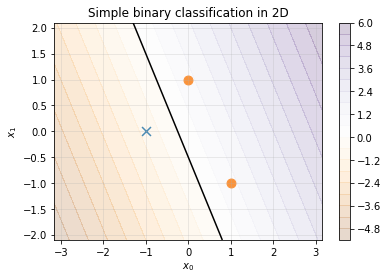

In [17]:



# plot the results
ff,aa = plt.subplots(1,1)
aa.scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
aa.scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )
aa.grid(alpha=0.3)

aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
aa.set_title('Simple binary classification in 2D')

a, b = separable_linear_svm_with_cvxopt(x2D*1., y*1.)
w = x2D.T.dot(y*a)
cs = plot_linear_classifier(xmin, xmax, ymin, ymax,w,aa,b)
ff.colorbar(cs, ax=aa)



## Dispersión de la arquitectura del modelo: los vectores soporte

El vector de pesos del clasificador se define mediante un subconjunto de las observaciones de entrenamiento, aquellos que obtuvieron su multiplicador de Lagrange correspondiente estrictamente positivo: 

$$\alpha_s>0 \Rightarrow \mathbf x_s \mbox{ es un vector soporte}$$

Estas observaciones con multiplicador de Lagrange positivo se conocen como **vectores soporte** dado que son los *vectores* (observaciones en un espacio vectorial) que sostienen  (*support* en inglés) la arquitectura del clasificador. En este sentido, si en lugar del conjunto de entrenamiento usamos exclusivamente los vectores soporte para entrenar el clasificador, obtendremos **el mismo clasificador**.


     pcost       dcost       gap    pres   dres
 0: -8.5417e-01 -2.1597e+00  1e+00  2e-16  2e+00
 1: -1.0446e+00 -1.1125e+00  7e-02  2e-16  3e-01
 2: -1.1111e+00 -1.1166e+00  6e-03  2e-16  5e-03
 3: -1.1111e+00 -1.1112e+00  6e-05  4e-16  5e-05
 4: -1.1111e+00 -1.1111e+00  6e-07  2e-16  5e-07
 5: -1.1111e+00 -1.1111e+00  6e-09  2e-16  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5631e+00 -3.3724e+00  2e+01  4e+00  2e+00
 1: -1.1757e+00 -2.7314e+00  5e+00  7e-01  3e-01
 2: -8.5679e-01 -1.4127e+00  6e-01  4e-16  3e-15
 3: -1.0365e+00 -1.1416e+00  1e-01  3e-16  5e-16
 4: -1.1093e+00 -1.1120e+00  3e-03  1e-16  2e-16
 5: -1.1111e+00 -1.1111e+00  3e-05  2e-16  2e-16
 6: -1.1111e+00 -1.1111e+00  3e-07  2e-16  2e-16
Optimal solution found.


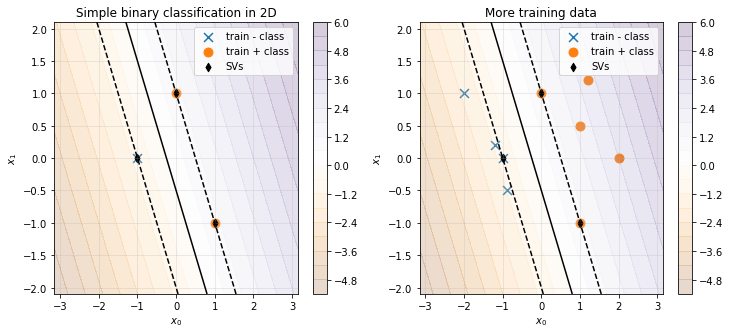

In [18]:
x2D_e = np.array([[-1,0], [0,1], [1,-1], [-0.9, -0.5], [-1.2, 0.2], [-2.,1.], [2.,0], [1,.5], [1.2,1.2]])
y_e = np.array([-1,1,1,-1,-1,-1,1 ,1., 1.])

# plot the results
ff,aa = plt.subplots(1,2, figsize=(12,5))
aa[0].scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
aa[0].scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )
aa[0].grid(alpha=0.3)

aa[0].set_xlabel('$x_0$')
aa[0].set_ylabel('$x_1$')
aa[0].set_title('Simple binary classification in 2D')


a, b = separable_linear_svm_with_cvxopt(x2D*1., y*1.)
w = x2D.T.dot(y*a)
cs = plot_linear_classifier(xmin, xmax, ymin, ymax,w,aa[0],b, margin=True)
plot_support_vectors(x2D,y,w,b,aa[0])
ff.colorbar(cs, ax=aa[0])
aa[0].legend()

aa[1].scatter(x2D_e[y_e==-1,0], x2D_e[y_e==-1,1], marker='x', s=80, label='train - class' )
aa[1].scatter(x2D_e[y_e==1,0], x2D_e[y_e==1,1], marker='o', s=80, label='train + class' )
aa[1].grid(alpha=0.3)

aa[1].set_xlabel('$x_0$')
aa[1].set_ylabel('$x_1$')
aa[1].set_title('More training data')

a, b = separable_linear_svm_with_cvxopt(x2D_e*1., y_e*1.)
w = x2D_e.T.dot(y_e*a)
cs = plot_linear_classifier(xmin, xmax, ymin, ymax,w,aa[1],b, margin=True)
plot_support_vectors(x2D_e,y_e,w,b,aa[1])
ff.colorbar(cs, ax=aa[1])
aa[1].legend()

  

In [19]:
print("Lagrange Multipliers after the optimization")
print(np.round(a,3))

Lagrange Multipliers after the optimization
[1.111 0.889 0.222 0.    0.    0.    0.    0.    0.   ]


## Dualidad de la solución

El hecho de que el vector de pesos del clasificador, $\mathbf w$, sea una combinación lineal de algunas de las observaciones del conjunto de entrenamiento nos permite estudiar la influencia de cada uno de estos vectores soporte en la clasificación de cada observación de test.
$$
f(\mathbf x) = \sum_{i=1}^n{y_i\alpha_i\mathbf x_i^\top} \mathbf x 
$$

La siguiente figura representa el efecto por separado de cada uno de los vectores soporte en la clasificación. En el ejemplo bajo estudio, tenemos 3 vectores soporte, luego la clasificación se basa en tres contribuciones independientes

$$
f(\mathbf x) = \sum_{i=1}^3{y_i\alpha_i\mathbf x_i^\top} \mathbf x 
$$
$$
= y_1\alpha_1\mathbf x_1^\top \mathbf x + y_2\alpha_2\mathbf x_2^\top \mathbf x + y_3\alpha_3\mathbf x_3^\top \mathbf x
$$
$$
= f_1(\mathbf x) + f_2(\mathbf x) + f_3(\mathbf x)
$$


     pcost       dcost       gap    pres   dres
 0: -8.5417e-01 -2.1597e+00  1e+00  2e-16  2e+00
 1: -1.0446e+00 -1.1125e+00  7e-02  2e-16  3e-01
 2: -1.1111e+00 -1.1166e+00  6e-03  2e-16  5e-03
 3: -1.1111e+00 -1.1112e+00  6e-05  4e-16  5e-05
 4: -1.1111e+00 -1.1111e+00  6e-07  2e-16  5e-07
 5: -1.1111e+00 -1.1111e+00  6e-09  2e-16  5e-09
Optimal solution found.


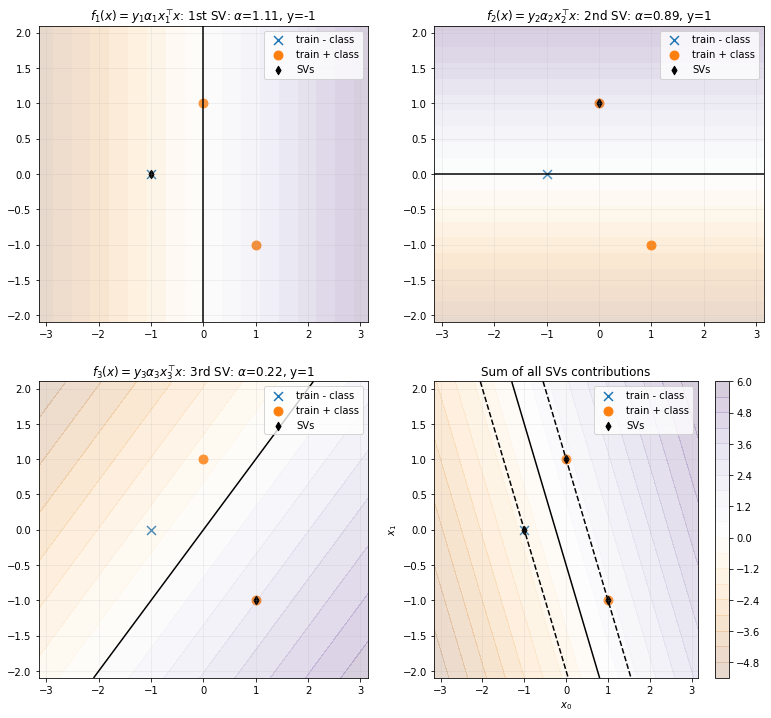

In [20]:
ff,aa = plt.subplots(2,2, figsize=(13,12))
ax= aa[1][1]
ax.scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
ax.scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )


ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_title('Sum of all SVs contributions')


a, b = separable_linear_svm_with_cvxopt(x2D*1., y*1.)
w = x2D.T.dot(y*a)
cs = plot_linear_classifier(xmin, xmax, ymin, ymax,w,ax,b, margin=True)
plot_support_vectors(x2D,y,w,b,ax)
ff.colorbar(cs, ax=ax)
ax.legend()
ax.grid(alpha=0.2)

for ii, ax, tit in zip(range(len(y)), [aa[0][0], aa[0][1], aa[1][0]], ['$f_1(x)=y_1\\alpha_1  x_1^\\top  x$: 1st SV', '$f_2(x)=y_2\\alpha_2  x_2^\\top  x$: 2nd SV', '$f_3(x)=y_3\\alpha_3  x_3^\\top  x$: 3rd SV']):
  ax.scatter([x2D[0,0]], x2D[0,1], marker='x', s=80, label='train - class' )
  ax.scatter(x2D[y==1,0], x2D[y==1,1], marker='o', s=80, label='train + class' )
  cs = plot_linear_classifier(xmin, xmax, ymin, ymax,y[ii]*a[ii]*x2D[ii,:],ax)
  ax.scatter(x2D[ii,0], x2D[ii,1],marker='d', color='black', label='SVs')
  ax.set_title("{0}: $\\alpha$={1:.2f}, y={2:d}".format(tit, a[ii], y[ii]))
  ax.legend()
  ax.grid(alpha=0.2)

# 3. SVMs en problemas no separables linealmente

Hasta este momento hemos visto que un clasificador de máximo margen puede ser una buena idea... pero hasta ahora todo lo que hemos hecho ha sido resolver problemas linealmente separables!

El gran potencial de la SVM (y de los métodos de *kernels* en general) se explota cuando hay que resolver problemas de clasificación que demandan modelos no lineales.

La propuesta de SVM para resolver este tipo de problemas es la siguiente:
- Sabemos cómo resolver problemas de clasificación que sean linealmente separables
- Podemos extender este resultado a situaciones no lineales en dos pasos:
 - **transformar** los datos mediante una **transformación no lineal** que proyecte los datos a un **nuevo espacio de características** donde los datos sean linealmente separables. Cada observación $\mathbf x_i$ se transforma en $\mathbf h(\mathbf x_i)$, con $\mathbf h()$ una transformación no lineal.
 - **aplicar la SVM** en el espacio transformado. Las etiquetas de las observaciones (la clase real) no cambian, pero hora la matriz de datos que asume el papek de $X$ en la formulación de la SVM (6) contiene a los vectores transformados $\mathbf h_i$ como filas...

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: No contour levels were found within the data range.
  


     pcost       dcost       gap    pres   dres
 0: -1.4932e+01 -3.1070e+01  2e+01  2e-16  2e+00
 1: -3.5654e+01 -3.6152e+01  5e-01  2e-15  1e+00
 2: -2.4984e+03 -2.5001e+03  2e+00  2e-13  1e+00
 3: -3.7199e+06 -3.7199e+06  3e+01  4e-10  1e+00
 4: -1.9670e+11 -1.9670e+11  1e+06  3e-05  1e+00
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres
 0: -3.3094e+00 -9.1037e+00  6e+00  1e-15  2e+00
 1: -3.8625e+00 -5.2732e+00  1e+00  5e-16  5e-01
 2: -5.8059e+00 -7.3582e+00  2e+00  1e-15  2e-01
 3: -6.1745e+00 -6.3915e+00  2e-01  1e-15  3e-02
 4: -6.2460e+00 -6.2701e+00  2e-02  1e-15  1e-03
 5: -6.2586e+00 -6.2588e+00  2e-04  2e-15  1e-05
 6: -6.2587e+00 -6.2587e+00  2e-06  9e-16  1e-07
 7: -6.2587e+00 -6.2587e+00  2e-08  1e-15  1e-09
Optimal solution found.
[[ 0.2107699   1.3834423 ]
 [ 0.29245218  0.05457156]
 [ 1.00313477  0.04265854]
 [ 0.31625122  1.40183053]
 [ 1.07063158 -1.38258917]
 [ 0.30787832  0.74470837]
 [ 0.97060304  1.4581674 ]
 [ 1.12825338 -1.040

Text(0.5, 1, 'Input space')

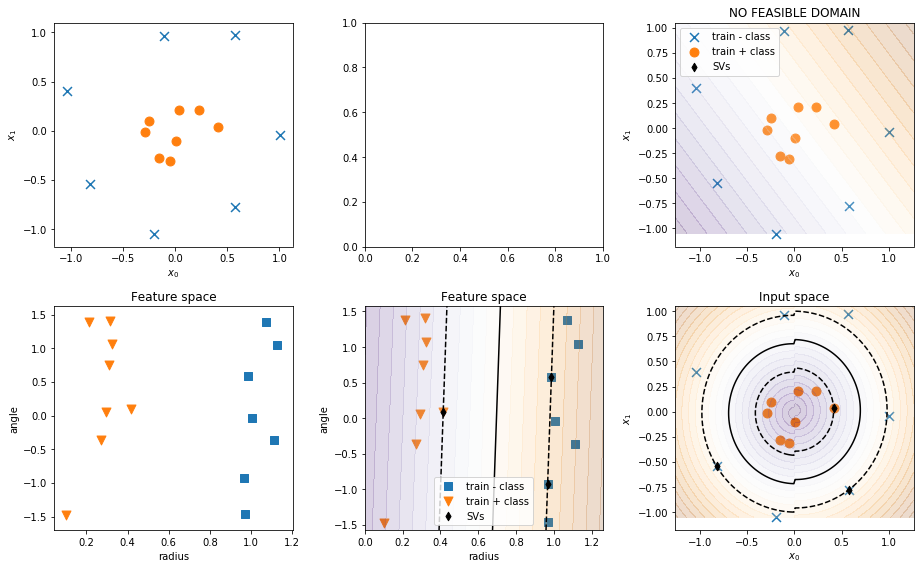

In [21]:
from sklearn.datasets.samples_generator import make_circles
nc = 15
xc, yc = make_circles(nc, factor=0.3, noise=.1, random_state=42)
yc[yc==0]=-1
ff,ax = plt.subplots(2,3, figsize=(13,8))
aa=ax[0][0]
aa.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')

aa = ax[0,2]
aa.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
a, b = separable_linear_svm_with_cvxopt(xc, yc*1.)
w = xc.T.dot(yc*a)
cs = plot_linear_classifier(-1.2, 1.2, -1, 1,w,aa,b, margin=True)
plot_support_vectors(xc,yc,w,b,aa)

aa.set_title('NO FEASIBLE DOMAIN')
aa.legend()

# paso a coordenadas polares

r = np.sqrt(np.sum((xc**2),1))
phi = np.arctan(xc[:,1]/xc[:,0])



hc = np.vstack((r.T,phi.T)).T
aa = ax[1][0]
aa.scatter(hc[yc==-1,0], hc[yc==-1,1], marker='s', s=80, label='train - class' )
aa.scatter(hc[yc==1,0], hc[yc==1,1], marker='v', s=80, label='train + class' )
aa.set_title('Feature space')
aa.set_xlabel('radius')
aa.set_ylabel('angle')


aa = ax[1][1]
aa.scatter(hc[yc==-1,0], hc[yc==-1,1], marker='s', s=80, label='train - class' )
aa.scatter(hc[yc==1,0], hc[yc==1,1], marker='v', s=80, label='train + class' )

aa.set_xlabel('radius')
aa.set_ylabel('angle')

a, b = separable_linear_svm_with_cvxopt(hc, yc*1.)
w = hc.T.dot(yc*a)
cs = plot_linear_classifier(0, 1.2, -1.5, 1.5,w,aa,b, margin=True)
plot_support_vectors(hc,yc,w,b,aa)

aa.set_title('Feature space')
aa.legend()
ff.tight_layout()


aa=ax[1][2]
aa.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')

cs = plot_radius_angle_classifier(-1.2, 1.2, -1, 1,w,aa,b, margin=True)
plot_radius_angle_support_vectors(xc,yc,w,b,aa)
aa.set_title('Input space')


En la Figura de arriba podemos ver un ejemplo sencillo de aplicación de este método.
- Arriba, izquierda: problema de clasificación 2D que no es linealmente separable

- Arriba, derecha: si intentamos resolver el problema de la SVM para el caso linealmente separable el optimizador explota porque el problema no tiene solución: **es imposible separar los círculos de las cruces con una recta sin cometer errores de clasificación**

- Abajo, izquierda: aplicamos una transformación a los datos, transformamos las coordenadas cartesianas en polares:
    - *radio* $r = \sqrt{x_0^2 + x_1^2}$
    - *ángulo* $\phi = \tan^{-1}\frac{x_1}{x_0}$
    - Cada punto $\mathbf x$ se transforma en $\mathbf h$
$$
    \mathbf x = \left [ \begin{array}{c} x_0 \\ x_1 \end{array}\right] \longrightarrow \mathbf h(\mathbf x) = \left [ \begin{array}{c} h_0 = r(\mathbf x) = \sqrt{x_0^2 + x_1^2} \\ h_1 =\phi(\mathbf x) = \tan^{-1}\frac{x_1}{x_0}\end{array}\right]
$$
- Abajo, centro. Ahora podemos aplicar la SVM en el **espacio transformado** porque los datos, en ese espacio, **sí son linealmente separables**.

- Abajo, derecha. El clasificador lineal en el espacio transformado es equivalente a un clasificador no lineal en el espacio original donde vive $\mathbf x$

## Encontrar una proyección para este método es complicado...

Hemos encontrado un método para aplicar SVM a cualquier problema de clasificación binaria, separable o no... si somos capaces de **encontrar la transformación apropiada** que nos lleva nuestro problema no-linealmente separable en el espacio de datos original a un **nuevo espacio de características** en el que los datos **sí sean linealmente separables**.

La pega es que **encontrar la trasformación** que nos sirva adecuadamente en cada caso es un problema con una **dificultad inherente basante mayor** que encontrar un clasificador que obtenga unas prestaciones aceptables. 

Por ejemplo, ¿cuál sería la transformación que aplicaríais en el ejemplo de abajo?

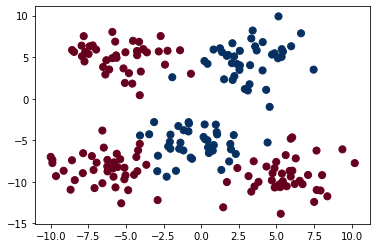

In [22]:
from sklearn.datasets.samples_generator import make_blobs
XX, YY = make_blobs(n_samples=200, centers=5,
                  random_state=10, cluster_std=2)
YY[YY==4] = -1
YY[YY==3] = -1
YY[YY==2] = 1
YY[YY==0] = -1
plt.figure()
plt.scatter(XX[:, 0], XX[:, 1], c=YY, s=50, cmap='RdBu')


## El truco del *kernel*

El **truco del kernel** es una herramienta matemática poderosa que nos ayuda en el proceso de encontrar una transformación no lineal apropiada básicamente **evitando que tengamos que buscar esa transformación**. En primer lugar presentemos lo que es una función de tipo *kernel*.


**Kernel**:
- Función matemática de dos argumentos $\kappa(\mathbf x_1, \mathbf x_2)$ y cuya salida es un número real
- **Simétrica**: $\kappa(\mathbf x_1, \mathbf x_2) = \kappa(\mathbf x_2, \mathbf x_1)$
- **Semidefinida positiva**: Dado un conjunto de observaciones cualesquiera $\{\mathbf x_1, \mathbf x_2,\dots,\mathbf x_n\}$, la matriz que se construye con los kernels de todas las combinaciones de elementos de ese conjunto tomados en parejas, es semidefinida positiva

$$
K = \left [\begin{array}{cccc} \kappa(\mathbf x_1, \mathbf x_1) & \kappa(\mathbf x_1, \mathbf x_2) & \cdots & \kappa(\mathbf x_1, \mathbf x_n) \\ \kappa(\mathbf x_2, \mathbf x_1) & \kappa(\mathbf x_2, \mathbf x_2) & \cdots & \kappa(\mathbf x_2, \mathbf x_n) \\ \vdots & \vdots & \ddots & \vdots \\ \kappa(\mathbf x_n, \mathbf x_1) & \kappa(\mathbf x_n, \mathbf x_2) & \cdots & \kappa(\mathbf x_n, \mathbf x_n) \end{array}\right]
$$

Dado un vector cualquiera de $n$ dimensiones, $\boldsymbol \beta \in \mathbb R^n$:

$$
\boldsymbol \beta ^\top K \boldsymbol \beta = \left [\begin{array}{cccc} \beta_1 & \beta_2 & \cdots & \beta_n \end{array}\right] \left [\begin{array}{cccc} \kappa(\mathbf x_1, \mathbf x_1) & \kappa(\mathbf x_1, \mathbf x_2) & \cdots & \kappa(\mathbf x_1, \mathbf x_n) \\ \kappa(\mathbf x_2, \mathbf x_1) & \kappa(\mathbf x_2, \mathbf x_2) & \cdots & \kappa(\mathbf x_2, \mathbf x_n) \\ \vdots & \vdots & \ddots & \vdots \\ \kappa(\mathbf x_n, \mathbf x_1) & \kappa(\mathbf x_n, \mathbf x_2) & \cdots & \kappa(\mathbf x_n, \mathbf x_n) \end{array}\right] \left [\begin{array}{c} \beta_1 \\ \beta_2 \\ \vdots \\ \beta_n \end{array}\right]  \ge 0
$$

Gracias a ser simétrica y semidefinida positiva, una función **kernel** puede interpretarse como un **producto escalar**. Recordamos brevemente el producto escalar entre dos vectores $\mathbf u$, $\mathbf v \in \mathbb R^n$
$$
\mathbf u = \left [\begin{array}{c} u_1 \\ u_2 \\ \vdots \\ u_n \end{array}\right], \quad \mathbf v = \left [\begin{array}{c} v_1 \\ v_2 \\ \vdots \\ v_n \end{array}\right] 
$$

simétrico
$$
\mathbf v^\top \mathbf u = \sum_{i=1}^n{u_iv_i} = \mathbf u^\top \mathbf v 
$$

semidefinido positivo
$$
\mathbf v^\top \mathbf v = \sum_{i=1}^n{v_iv_i} = \sum_{i=1}^n{v_i^2} \ge 0
$$





### Ejemplos de *kernels*:

- **Kernel lineal**: la transformación es trivial, consiste en no hacer nada $\mathbf h(\mathbf x) = \mathbf x$. Entonces
$$ \kappa(\mathbf x_1, \mathbf x_2) = \mathbf x_1^\top \mathbf x_2$$

- **Función de base radial** (RBF):
$$\kappa(\mathbf x_1, \mathbf x_2) = \exp\{-\gamma\|\mathbf x_1 - \mathbf x_2\|^2\}$$ donde $\gamma$ es un parámetro que toma valores reales y determina la anchura de la RBF 

- **Kernel Polinómico**: 
$$\kappa(\mathbf x_1, \mathbf x_2) = (\mathbf x_1^\top \mathbf x_2 + c)^d $$ donde $d$ es el grado del polinomio

- Además podemos construir kernels aplicando una exponencial a cualquier distancia

- Las combinaciones (sumas, productos) de kernels son a su vez kernels. Dados dos kernels diferentes $\kappa_1(\mathbf u, \mathbf v)$ y $\kappa_2(\mathbf u, \mathbf v)$:
    - $\kappa_s (\mathbf u, \mathbf v) = \kappa_1(\mathbf u, \mathbf v) + \kappa_2(\mathbf u, \mathbf v)$ es un kernel
    - $\kappa_p (\mathbf u, \mathbf v) = \kappa_1(\mathbf u, \mathbf v) \times \kappa_2(\mathbf u, \mathbf v)$ es un kernel

### Explotando el truco del kernel

Como un *kernel* es una función simétrica y semidefinida positiva, entonces **el truco del kernel** consiste en **asumir que existe** una transformación $\mathbf h()$ que nos lleva los vectores $\mathbf x_1$ y $\mathbf x_2$ a un cierto espacio de características $\mathcal H$ en el que **los productos escalares se calculan mediante la función kernel actuando sobre** $\mathbf x_1$ y $\mathbf x_2$.

En primer lugar revisamos la proyección:

$$
\mathbf h():\mathbf x_i \in \mathbb R^n \rightarrow \mathbf h(\mathbf x_i) \in \mathcal H \in \mathbb R^m
$$

$$
\mathbf x = \left [\begin{array}{c} x_1 \\ x_2 \\ \vdots \\ x_n \end{array}\right] \rightarrow \mathbf h(\mathbf x) = \left [\begin{array}{c} h_1(\mathbf x) \\ h_2(\mathbf x) \\ \vdots \\ \vdots \\ h_m(\mathbf x) \end{array}\right] = \left [\begin{array}{c} h_1 \\ h_2 \\ \vdots \\ \vdots \\ h_m \end{array}\right] = \mathbf h \in \mathcal H \in \mathbb R^m
$$

En el nuevo espacio de características $\mathcal H$ los productos escalares serían
$$
\mathbf h(\mathbf u)^\top \mathbf h(\mathbf v) = \sum_{j=1}^m h_j(\mathbf u)h_j(\mathbf v)
$$

Lo que nos garantiza el truco del kernel es que ese producto escalar en $\mathcal H$ se puede calcular evaluando el kernel correspondiente con los vectores en el espacio original.

En otras palabras, dada una función kernel $\kappa(\mathbf x_i, \mathbf x_j)$ tenemos la garantía de que existe una proyección $\mathbf h()$ asociada a este kernel que nos transforma los datos del espacio de entrada del kernel a un espacio de características $\mathcal H$. En este espacio $\mathcal H$ podemos calcular productos escalares entre vectores que viven en este espacio simplemente evaluando el kernel entre los vectores origen correspondientes. Es decir, podemos calcular el producto escalar entre dos elementos de $\mathcal H$, $\mathbf h_1$ y $\mathbf h_2$ **sin conocerlos explícitamente**:
- Encontrar los orígenes de $\mathbf h_1$ y $\mathbf h_2$ en el espacio de entrada a la proyección: $\mathbf x_1$ es el origen de $\mathbf h_1$ si se verifica que $\mathbf h_1 = \mathbf h(\mathbf x_1)$ y lo mismo para $\mathbf x_2$ y $\mathbf h_2$.
- Calcular el producto escalar usando el kernel: $\mathbf h_1^\top \mathbf h_2 = \kappa(\mathbf x_1, \mathbf x_2)$




Habíamos visto que una manera de extender un modelo lineal a escenarios que demandan modelos no lineales es aplicar una **transformación no lineal** a los datos de entrada que los lleve a un nuevo espacio de características en el que se pueda aplicar el modelo lineal. Pero encontrar esta transformación es un proceso muy complejo.

¿Y si el algoritmo que necesitamos aplicar en este espacio de características no necesitase conocer explícitamente los datos, solo sus productos escalares?

En este caso, si **sustituimos por evaluaciones de kernels todos los productos escalares** que aparecen en los algoritmos de entrenamiento y evaluación del modelo lineal, tenemos la garantía de que estamos aplicando el modelo lineal en el espacio de características inducido por el kernel, que se traduce en un modelo no lineal en el espacio de entrada.


## SVM con kernels

La SVM se puede **kernelizar** por estos dos motivos:

- La evaluación del clasificador (métodos `score`y `predict`) sólo requiere la participación de las observaciones exclusivamente a través de productos escalares. Para clasificar una observación del conjunto de test $\mathbf x_t$, necesitamos evaluar

$$ \hat y(\mathbf x_t) = \mbox{signo}\left(\mathbf w^{\top} \mathbf x_t + b\right).$$
Aplicando (3) tenemos 

$$ \hat y(\mathbf x_t) = \mbox{signo}\left(\sum_{i=1}^n{\alpha_iy_i\mathbf x_i^\top \mathbf x_t} + b\right) =  \mbox{signo}\left( \sum_{i=1}^n{\alpha_iy_i\kappa(\mathbf x_i,\mathbf x_t)} + b\right)$$ Por lo tanto podemos **reemplazar los productos escalares** entre observaciones que viven en el espacio original  **con evaluaciones de funciones kernel**. 

- El algoritmo de entrenamiento (método `fit`) que nos proporciona $\mathbf w$ y $b$ (es decir, que calcula $\boldsymbol \alpha$ a partir del conjunto de entrenamiento) emplea las observaciones del conjunto de entrenamiento única y exclusivamente a través de productos escalares:
$$
 \min_{\alpha_i} \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\mathbf x_i^\top \mathbf x_j  - \sum_{i=1}^n{\alpha_i} \qquad \qquad\mbox{(6)}
$$
$$\mbox{con } \alpha_i \ge 0 \qquad i=1,\dots,n$$
$$\mbox{sujeto a }\sum_{i=1}^n{\alpha_iy_i}=0$$


La única contribución de las observaciones del conjunto de entrenamiento dentro de la optimización es $\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\mathbf x_i^\top \mathbf x_j$. Esta sume tiene  los productos escalares de todas las parejas de observaciones de entrenamiento. Cada producto escalar $\mathbf x_i^{\top} \mathbf x_j \rightarrow \kappa(\mathbf x_i,\mathbf x_j)$ puede reemplazarse por un *kernel*. Por tanto, podemos resolver fácilmente la optimización en un espacio de características alternativo inducido por una función kernel simplemente reemplazando los productos escalares por kernels. En la asignación que hicimos antes cambiaríamos

- $$ P \leftarrow  \left [\begin{array}{cccc} y_1y_1\kappa(\mathbf x_1, \mathbf x_1) & y_1y_2\kappa(\mathbf x_1, \mathbf x_2) & \cdots & y_1y_n\kappa(\mathbf x_1, \mathbf x_n) \\ y_2y_1\kappa(\mathbf x_2, \mathbf x_1) & y_2y_2\kappa(\mathbf x_2, \mathbf x_2) & \cdots & y_2y_n\kappa(\mathbf x_2, \mathbf x_n) \\ \vdots & \vdots & \ddots & \vdots \\ y_ny_1\kappa(\mathbf x_n, \mathbf x_1) & y_ny_2\kappa(\mathbf x_n, \mathbf x_2) & \cdots & y_ny_n\kappa(\mathbf x_n, \mathbf x_n) \end{array}\right]$$


In [23]:
from sklearn.metrics.pairwise import rbf_kernel

def separable_rbf_svm_with_cvxopt(xall, yall, gamma):
    nn = xall.shape[0]
    
    # Identification of terms
    Kc = rbf_kernel(xall,xall,gamma=1)
    Yc = np.diag(yall)
    K = Yc.dot(Kc.dot(Yc))
    
    # a^TYKY a
    P = matrix(K)

    # -a^T1
    q = matrix(-np.ones(nn))

    # a_i >= 0
    G = matrix(-np.eye(nn))
    h = matrix(np.zeros(nn))

    # sum(a_iy_i)=0
    A = matrix(yall.astype(float), (1,nn))
    b = matrix(0.0)

    sol=solvers.qp(P, q, G, h, A, b)
    a = np.array([cc for cc in sol['x']])
    
    # To get b, we need one of the equations where the lagrange multiplier is strictly positive
    id_svs = np.where(a>1e-3) # threshold to distinguish 'computational zeros'

    # instead of using a single constrain, we take the average value of 
    # all constraints with a>0. It's more robust
    b = np.mean(yall[id_svs]-Kc[id_svs,:].dot(Yc.dot(a))) 
    return a, b
    


In [24]:
def plot_kernel_classifier(xc,yc,gamma,alpha,ax,b=0):
    # generate a grid of points to evaluate classifier
    xmin = np.min(xc[:,0])
    xmax = np.max(xc[:,0])
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   20) # or whatever values for x
    ymin = np.min(xc[:,1])
    ymax = np.max(xc[:,1])
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   20)   # or whatever values for y
    zz = z_grid(Xg, Yg, lambda x:rbf_kernel(x.reshape((1,2)), xc, gamma).dot(alpha)+b)
    X, Y = np.meshgrid(Xg, Yg)
    ax.contour(X, Y, zz.T, [0], colors='black')
    return ax.contourf(X, Y, zz.T, alpha=0.2)

In [25]:
def plot_kernel_classifier(xmin, xmax, ymin, ymax,xc,gamma,alpha,ax,b=0, margin=False, color='black',contr=True):
    # generate a grid of points to evaluate classifier
    
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   20) # or whatever values for x
    
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   20)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    Xshape = X.shape
    
    x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    zz = rbf_kernel(x_test, xc, gamma).dot(alpha) + b
    zz = zz.reshape(Xshape)
    if contr:
      ax.contour(X, Y, zz, [0], colors=color)
    if margin:
      ax.contour(X, Y, zz, [-1,1], linestyles='dashed', colors=color)
    return ax.contourf(X, Y, zz, alpha=0.2, cmap='PuOr')

     pcost       dcost       gap    pres   dres
 0: -3.9129e+00 -1.0233e+01  6e+00  6e-16  2e+00
 1: -4.5528e+00 -5.7221e+00  1e+00  3e-16  4e-01
 2: -5.3365e+00 -6.1880e+00  9e-01  9e-16  1e-01
 3: -5.4136e+00 -5.5312e+00  1e-01  7e-16  1e-02
 4: -5.4423e+00 -5.4463e+00  4e-03  7e-16  1e-04
 5: -5.4432e+00 -5.4433e+00  2e-04  3e-16  1e-06
 6: -5.4432e+00 -5.4432e+00  3e-06  7e-16  1e-08
Optimal solution found.


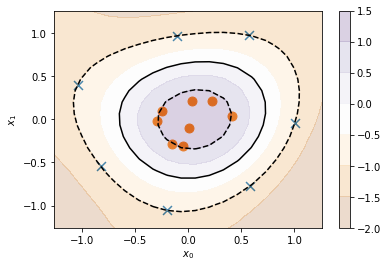

In [26]:
ff,aa = plt.subplots(1,1)
aa.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
ac,bc = separable_rbf_svm_with_cvxopt(xc, yc, 1)
cs = plot_kernel_classifier(-1.2, 1.2, -1.2, 1.2,xc,1,ac*yc,aa,bc,True)
_ = ff.colorbar(cs, ax=aa)

## SVM con kernels en el espacio dual

Antes comprobamos que la SVM lineal también puede interpretarse como una combinación lineal de clasificadores sencillos, cada uno definido con cada vector soporte.  Esta interpretación también puede extenderse fácilmente al caso de la SVM no lineal construida mediante el truco del kernel.

En el ejemplo de la figura de arriba, la clasificación de cada posible observación de test se realiza mediante el siguiente cálculo:

$$
f(\mathbf x_t) = \mbox{signo}\left( \sum_{i=1}^{n=15}{\alpha_iy_i\kappa(\mathbf x_i,\mathbf x_t)} + b\right)
$$

Como sólo hay 10 vectores soporte, la suma en realidad tiene sólo 10 términos

$$
f(\mathbf x_t) = \mbox{signo}\left(\alpha_2y_2\kappa(\mathbf x_2,\mathbf x_t)+\alpha_3y_3\kappa(\mathbf x_3,\mathbf x_t) +\alpha_5y_5\kappa(\mathbf x_5,\mathbf x_t) +  \alpha_7y_7\kappa(\mathbf x_7,\mathbf x_t) + \alpha_8y_8\kappa(\mathbf x_8,\mathbf x_t) + \alpha_{10}y_{10}\kappa(\mathbf x_{10},\mathbf x_t) + \alpha_{11}y_{11}\kappa(\mathbf x_{11},\mathbf x_t) +\alpha_{13}y_{13}\kappa(\mathbf x_{13},\mathbf x_t) + \alpha_{14}y_{14}\kappa(\mathbf x_{14},\mathbf x_t) +  \alpha_{15}y_{15}\kappa(\mathbf x_{15},\mathbf x_t) + b \right)
$$

Cada uno de los términos kernel de la suma puede interpretarse como un clasificador individual local que intenta asignar la clase verdadera del vector soporte correspondiente ($y_i$) con una intensidad que depende del peso $\alpha_i$ y también de lo cerca que esté la observación de test $\mathbf x_t$ del vector soporte correspondiente ($\mathbf x_i$).

La siguente figura muestra cada uno de esos clasificadores individuales 

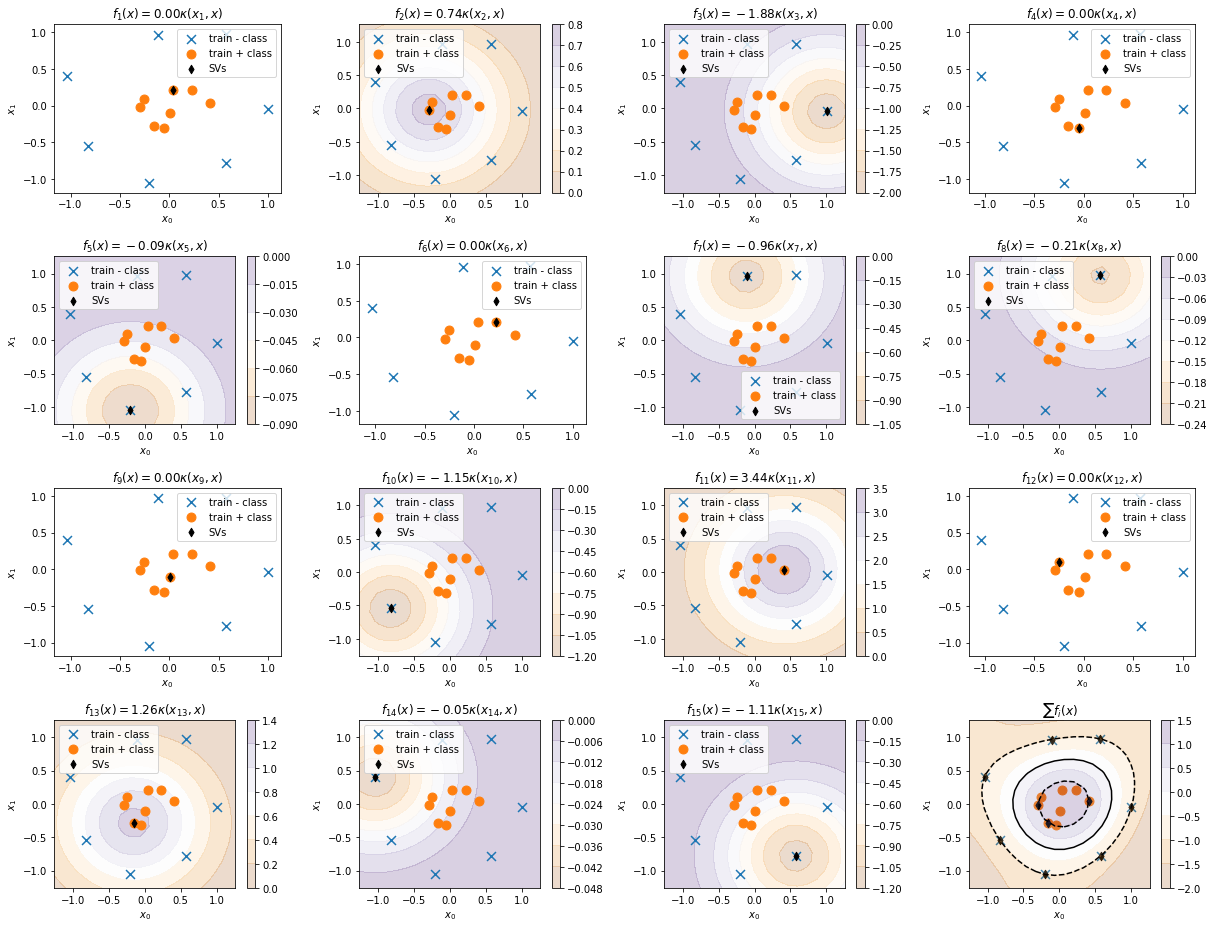

In [27]:
ff, aa = plt.subplots(4,4,figsize=(17,13))
col = 0
row = 0
for c in range(nc):
  ax = aa[row][col]
  if ac[c] > 1e-4:
    cs = plot_kernel_classifier(-1.2, 1.2, -1.2, 1.2,xc[c,:].reshape(1,-1),1,yc[c]*ac[c],ax,0,False,contr= False)
    _ = ff.colorbar(cs, ax=ax)
  ax.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
  ax.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
  ax.scatter(xc[c,0], xc[c,1],marker='d', color='black', label='SVs')
  ax.set_xlabel('$x_0$')
  ax.set_ylabel('$x_1$')
  ax.set_title('$f_{2}{0:d}{3}(x)={1:.2f}\\kappa(x_{2}{0:d}{3},x)$'.format(c+1,yc[c]* ac[c],"{","}"))
  ax.legend()
  col += 1
  if col == 4:
    col = 0
    row += 1


ax = aa[3][3]
ax.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
ax.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
id_svs =  np.where(ac > 1e-3)[0]
ax.scatter(xc[id_svs,0], xc[id_svs,1],marker='d', color='black', label='SVs')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_title('$\\sum f_i(x)$')
cs = plot_kernel_classifier(-1.2, 1.2, -1.2, 1.2,xc,1,ac*yc,ax,bc,True)
_ = ff.colorbar(cs, ax=ax)

ff.tight_layout()

El truco del kernel se aplica indistintamente de que la proyección al espacio de características sea más o menos evidente...

     pcost       dcost       gap    pres   dres
 0: -3.4573e+01 -1.0379e+02  7e+01  6e-16  2e+00
 1: -3.8928e+01 -5.1256e+01  1e+01  1e-15  4e-01
 2: -4.1295e+01 -4.3588e+01  2e+00  2e-15  4e-02
 3: -4.1544e+01 -4.1932e+01  4e-01  1e-15  5e-03
 4: -4.1612e+01 -4.1672e+01  6e-02  2e-15  3e-16
 5: -4.1625e+01 -4.1628e+01  3e-03  2e-15  3e-16
 6: -4.1626e+01 -4.1626e+01  2e-04  2e-15  2e-16
 7: -4.1626e+01 -4.1626e+01  7e-06  2e-15  2e-16
Optimal solution found.


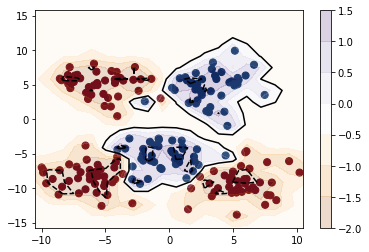

In [28]:
ff,aa = plt.subplots(1,1)
aa.scatter(XX[:, 0], XX[:, 1], c=YY, s=50, cmap='RdBu')
gamma = .5
acc,bcc = separable_rbf_svm_with_cvxopt(XX, YY, gamma)
plot_kernel_classifier(-10, 10, -15, 15,XX,1,acc*YY,aa,bcc,True)
_ = ff.colorbar(cs, ax=aa)

# 4. Margen blando

## Algunas veces los kernels no son la opción más razonable

En muchas aplicaciones del mundo real los conjuntos de datos van a contener ruido, algunos **outliers**, algunas características medidas con error, etc.

En estas situaciones puede ser preferible asumir que algunas observaciones del conjunto de entrenamiento van a acabar siendo errores de clasificación a cambio de conseguir una **frontera de clasificación más suave** que nos proporcione una mejor **capacidad de generalización**.

En el siguiente ejemplo vemos que una SVM con kernels nos consigue separar el conjunto de entrenamiento con 0 errores de clasificación, pero la función de clasificación "blanda" (antes de tomar el signo) es poco "suave".

     pcost       dcost       gap    pres   dres
 0: -1.2011e+01 -3.2141e+01  2e+01  9e-16  2e+00
 1: -2.4356e+01 -2.9223e+01  5e+00  2e-15  1e+00
 2: -9.8613e+01 -1.0947e+02  1e+01  1e-14  1e+00
 3: -2.8483e+02 -3.1150e+02  3e+01  3e-14  1e+00
 4: -8.5696e+02 -9.1923e+02  6e+01  6e-14  1e+00
 5: -2.3798e+03 -2.5283e+03  1e+02  6e-14  1e+00
 6: -4.3005e+03 -4.5517e+03  3e+02  4e-13  1e+00
 7: -9.3789e+03 -9.9040e+03  5e+02  1e-12  1e+00
 8: -1.1614e+04 -1.2271e+04  7e+02  2e-12  1e+00
 9: -1.6625e+04 -1.7592e+04  1e+03  1e-12  1e+00
10: -4.0780e+04 -4.3708e+04  3e+03  5e-12  1e+00
11: -8.8903e+04 -9.7828e+04  9e+03  4e-12  1e+00
12: -2.9158e+05 -3.5854e+05  7e+04  6e-11  9e-01
13: -5.1296e+05 -6.4044e+05  1e+05  3e-11  5e-01
14: -5.6707e+05 -5.9702e+05  3e+04  3e-11  6e-02
15: -5.6786e+05 -5.6824e+05  4e+02  7e-11  8e-04
16: -5.6786e+05 -5.6787e+05  4e+00  1e-10  8e-06
17: -5.6786e+05 -5.6786e+05  4e-02  1e-10  8e-08
Optimal solution found.


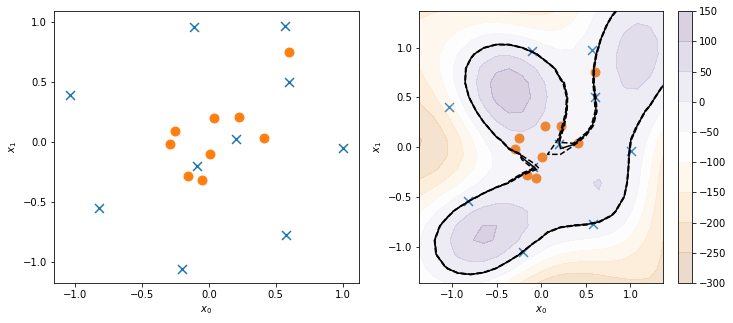

In [29]:
xk = np.vstack((xc, np.array([[0.2,0.03],[-0.09,-0.2],[.6, 0.75],[0.6, 0.5]])))
yk = np.hstack((yc,np.array([-1., -1., 1. , -1.])))

ff2,aa2 = plt.subplots(1,2, figsize=(12,5))
aa = aa2[0]
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
aa = aa2[1]
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
akk,bkk = separable_rbf_svm_with_cvxopt(xk, yk, 10)
cs = plot_kernel_classifier(-1.3, 1.3, -1.3, 1.3,xk,1,akk*yk,aa,bkk,True)
_ = ff.colorbar(cs, ax=aa)

Fijaos cómo esta situación no es estable en absoluto dado que muchas cruces (elementos de la clase negativa) están muy cerca de regiones con una alta activación de la clase positiva (áreas coloreadas de violeta).

## El margen blando

Emplear kernels hasta conseguir separar perfectamente el conjunto de entrenamiento no es siempre la mejor opción... El **riesgo de sobreajuste** puede ser grande ya que un kernel RBF dotado de una resolución super fina (gaussiana súper estrecha) es capaz de dibujar fronteras de clasificación arbitrariamente complejas que clasifiquen con cero errores cualquier conjunto de entrenamiento, pero cuyo **error en generalización** resulte mucho más pobre.

En estas situaciones es más aconsejable dejar que el algoritmo de entrenamiento de la SVM tolere algunos errores de clasificación entre las observaciones del conjunto de entrenamiento  con el propósito de conseguir una frontera de clasificación mucho más suave y que generalice mejor.

Matemáticamente esto se consigue relajando las restricciones que definen la SVM mediante la introducción de un conjunto de variables auxiliares no negativas (*slack variables*) $\{\xi_i\}_{i=1}^n$.

El problema de optimización se transforma en
$$ \min_{\mathbf w} \frac{1}{2}\|\mathbf w\|^2 + C\sum_{i=1}^n{\xi_i} $$
$$ \mbox{subject to } y_i (\mathbf w^\top \mathbf x_i + b) \ge 1 - \xi_i,\qquad i=1,\dots,n \qquad \qquad\mbox{(7)}$$ 
$$\xi_i \ge 0\qquad $$

$C$ es un hiperparámetro definido por el usuario con conocimiento a priori que controla el **compromiso** entre la maximización del margen ($ \min_{\mathbf w,b} \frac{1}{2}\|\mathbf w\|^2$) y la aparición de **violaciones del margen por parte de algunas de las observaciones del conjunto de entrenamiento** ($\min_{\mathbf w,b} \sum_{i=1}^n{\xi_i}$). 

Las observaciones del conjunto de entrenamiento correctamente clasificadas con margen suficiente
$$
y_i (\mathbf w^\top \mathbf x_i + b) \ge 1 
$$
se corresponden con un valor nulo de su variable auxiliar correspondiente $\xi_j=0$; 

por contra, las observaciones del conjunto de entrenamiento que violan la restricción del margen 
$$
y_j (\mathbf w^\top \mathbf x_j + b) < 1 
$$

reciben $\xi_j>0$. De este modo $\xi_j$ "ayuda" a que la observación $\mathbf x_j $ "cumpla" con la restricción

$$
y_j (\mathbf w^\top \mathbf x_j + b) + \xi_j \ge 1 
$$

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/xi.png' width=500 />



Para resolver la SVM con margen blando introducimos las restricciones en el funcional usando multiplicadores de Lagrange $\alpha_i$ and $m_i$, $i=1,\dots,n$

$$ \min_{\mathbf w,b, \xi_i} \max_{\alpha_i,m_i} \frac{1}{2}\|\mathbf w\|^2 + C\sum_{i=1}^n{\xi_i} -\sum_{i=1}^n{\alpha_i\left ( y_i (\mathbf w^\top \mathbf x_i + b) - (1 - \xi_i) \right)} - \sum_{i=1}^n m_i\xi_i \qquad \qquad (8)$$

Desarrollamos la segunda suma:

$$ \min_{\mathbf w,b, \xi_i} \max_{\alpha_i,m_i} \frac{1}{2}\|\mathbf w\|^2 + C\sum_{i=1}^n{\xi_i} -\sum_{i=1}^n{\alpha_i y_i \mathbf w^\top \mathbf x_i} -  \sum_{i=1}^n{\alpha_i y_ib} + \sum_{i=1}^n{\alpha_i} - \sum_{i=1}^n{\alpha_i \xi_i} - \sum_{i=1}^n m_i\xi_i $$


### Eliminar la dependencia con $\mathbf w$

Tomando gradientes con respecto a $\mathbf w$ descubrimos nuevamente que el vector de pesos del clasificador puede escribirse como una **combinación lineal** de las observaciones del conjunto de entrenamiento:

$$\mathbf w - \sum_{i=1}^n{\alpha_i y_i \mathbf w^\top \mathbf x_i} = \mathbf 0 \Rightarrow \mathbf w = \sum_{i=1}^n{\alpha_i y_i \mathbf x_i} \qquad \qquad (9)$$


Introduciendo el resultado (9) en (8) y sustituyendo los productos escalares por  **kernels**:

$$ \min_{b,\xi_i} \max_{\alpha_i, m_i} \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\kappa(\mathbf x_i, \mathbf x_j) + C\sum_{i=1}^n{\xi_i} - \sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\kappa(\mathbf x_i, \mathbf x_j)-   \sum_{i=1}^n{\alpha_i  y_i b} + \sum_{i=1}^n{\alpha_i} - \sum_{i=1}^n{\alpha_i \xi_i} - \sum_{i=1}^n m_i\xi_i $$ 

$$
 = \min_{b, \xi_i} \max_{\alpha_i, m_i} -\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\kappa(\mathbf x_i, \mathbf x_j) + C\sum_{i=1}^n{\xi_i} -   \sum_{i=1}^n{\alpha_i  y_i b} + \sum_{i=1}^n{\alpha_i} - \sum_{i=1}^n{\alpha_i \xi_i} - \sum_{i=1}^n m_i\xi_i \qquad \qquad\mbox{(10)}
$$


### Eliminar la dependencia con $b$

La optimización con respecto del parámetro $b$ también se convierte en una restricción sobre las $\alpha_i$. Derivando con respecto de $b$ e igualando a 0:

$$
\sum_{i=1}^n{\alpha_i  y_i} = 0 \qquad \qquad\mbox{(10)}
$$

Introduciendo este resultado en la optimización principal  llegamos a

$$
\min_{\xi_i}\max_{\alpha_i, m_i} -\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\kappa(\mathbf x_i, \mathbf x_j) + C\sum_{i=1}^n{\xi_i} + \sum_{i=1}^n{\alpha_i} - \sum_{i=1}^n{\alpha_i \xi_i} - \sum_{i=1}^n m_i\xi_i \qquad \qquad\mbox{(11)}
$$
$$
\mbox{sujeto a: }\sum_{i=1}^n{\alpha_i  y_i} = 0
$$


### Eliminar la dependencia con $\xi_i$

La dependencia con las variables auxiliares también se puede transformar en una restricción sobre $\boldsymbol \alpha$. Tomando derivadas con respecto a cada una de las $\{\xi_i\}_{i=1}^n$ e igualando a cero:

$$
C -\alpha_i - m_i = 0 \Rightarrow \alpha_i = C - m_i \qquad \qquad\mbox{(12)}
$$

Teniendo en cuenta que tanto $\alpha_i \ge 0$ como $m_i \ge 0$ podemos cambiar la ecuación de arriba por
$$
0 \le \alpha_i \le C \quad i=1,\dots,n \qquad \qquad\mbox{(13)}
$$

Introduciendo (12) en la optimización principal,  añadiendo la restricción (13) y cambiando la maximización por una minimización llegamos al problema

$$
\min_{\alpha_i} \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\kappa(\mathbf x_i, \mathbf x_j) - \sum_{i=1}^n{\alpha_i}  \qquad \qquad\mbox{(14)}
$$
$$
\mbox{sujeto a: }\sum_{i=1}^n{\alpha_i  y_i} = 0
$$
$$
\mbox{y: }0 \le \alpha_i \le C \quad i=1,\dots,n
$$


El problema (14) puede resolverse también con programación cuadrática, de hecho este problema sí puede resolverse con la implementación de sklearn. En la siguiente figura vemos la comparación entre forzar una solución separable y emplear un margen blando.

     pcost       dcost       gap    pres   dres
 0: -1.2011e+01 -3.2141e+01  2e+01  9e-16  2e+00
 1: -2.4356e+01 -2.9223e+01  5e+00  2e-15  1e+00
 2: -9.8613e+01 -1.0947e+02  1e+01  1e-14  1e+00
 3: -2.8483e+02 -3.1150e+02  3e+01  3e-14  1e+00
 4: -8.5696e+02 -9.1923e+02  6e+01  6e-14  1e+00
 5: -2.3798e+03 -2.5283e+03  1e+02  6e-14  1e+00
 6: -4.3005e+03 -4.5517e+03  3e+02  4e-13  1e+00
 7: -9.3789e+03 -9.9040e+03  5e+02  2e-12  1e+00
 8: -1.1614e+04 -1.2271e+04  7e+02  2e-12  1e+00
 9: -1.6625e+04 -1.7592e+04  1e+03  1e-12  1e+00
10: -4.0780e+04 -4.3708e+04  3e+03  4e-12  1e+00
11: -8.8903e+04 -9.7828e+04  9e+03  2e-11  1e+00
12: -2.9158e+05 -3.5854e+05  7e+04  4e-11  9e-01
13: -5.1296e+05 -6.4044e+05  1e+05  7e-11  5e-01
14: -5.6707e+05 -5.9702e+05  3e+04  6e-11  6e-02
15: -5.6786e+05 -5.6824e+05  4e+02  9e-11  8e-04
16: -5.6786e+05 -5.6787e+05  4e+00  1e-10  8e-06
17: -5.6786e+05 -5.6786e+05  4e-02  3e-10  8e-08
Optimal solution found.


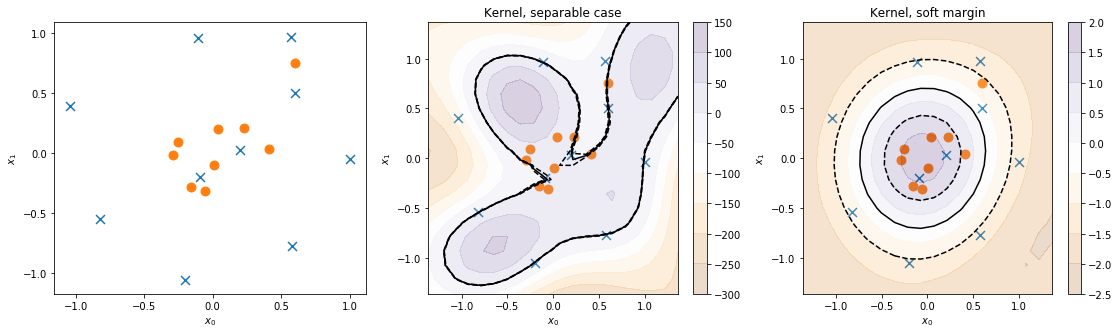

In [30]:
ff2,aa2 = plt.subplots(1,3, figsize=(19,5))
aa = aa2[0]
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
aa = aa2[1]
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
aa.set_title('Kernel, separable case')
akk,bkk = separable_rbf_svm_with_cvxopt(xk, yk, 10)
cs = plot_kernel_classifier(-1.3, 1.3, -1.3, 1.3,xk,1,akk*yk,aa,bkk,True)
_ = ff.colorbar(cs, ax=aa)

aa = aa2[2]
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
aa.set_title('Kernel, soft margin')
from sklearn import svm
model = svm.SVC(C=1,kernel='rbf', gamma=0.1)
model.fit(xk,yk)
akkyk = model.dual_coef_.T 
bkk = model.intercept_
cs = plot_kernel_classifier(-1.3, 1.3, -1.3, 1.3,model.support_vectors_,1,akkyk,aa,bkk,True)
_ = ff.colorbar(cs, ax=aa)

# 5. Función de coste y regularización: otro punto de vista para explicar las SVMs

En general el diseño de un modelo de clasificación automático pasa por la optimización de una función de coste que depende del número de errores que se cometan al tratar de clasificar con el modelo las observaciones de conjunto de entrenamiento, más algunos términos de **regularización** que protejan contra el riesgo de sobreajuste. Este paradigma también puede aplicarse a la SVM con margen blando.

En la optimización que proporciona la SVM estos dos términos son fáciles de identificar:
- Función de pérdidas: *hinge loss* $\sum_{i=1}^n\xi_i$. Los errores en el conjunto de entrenamiento tienen un valor positivo de variable auxiliar $\xi_i>0$, mientras que las observaciones correctamente clasificadas (en el lado correcto del margen) presentan $\xi_j=0$
- Regularización: La norma $L_2$ del vector de pesos $\|\mathbf w\|^2$

La figura de abajo representa algunas de las funciones de pérdida más comunes evaluadas en función de la distancia de la observación a la frontera de clasificación (margen funcional).

La función de pérdidas **zero-one** cuenta los errores de clasificación. Si nuestro objetivo es maximizar la precisión del clasificador, la función de pérdidas *zero-one* parece la opción natural e inmediata para optimizar. Sin embargo, esta función **no es derivable** debido a la discontinuidad que presenta en 0.

Algunas alternativa:
- **Hinge loss**: No es derivable pero por lo menos es continua. Es la que usa SVM
- **Coste cuadrático**: Continua y derivable. Penaliza en exceso a los *outliers*.

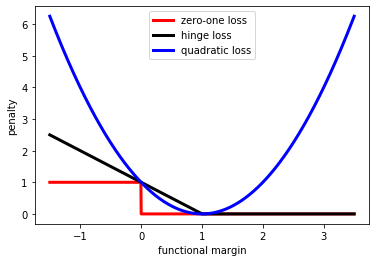

In [31]:
margin = np.linspace(-1.5,3.5,1000) 
hinge = 1 - margin
hinge[hinge<0] = 0
zero_one = np.ones(len(margin))
zero_one[margin>0] = 0
quad = (1-margin)**2
#quad[margin>1] = 0

plt.figure()

plt.plot(margin, zero_one, 
         label='zero-one loss',
        linewidth=3,
        color='red')
plt.plot(margin, hinge, 
         label='hinge loss',
        linewidth=3,
        color='black')

plt.plot(margin, quad, 
         label='quadratic loss',
        linewidth=3,
        color='blue')
plt.xlabel('functional margin')
plt.ylabel('penalty')
_ = plt.legend()


La gráfica muestra cómo la *hinge loss* y las pérdidas cuadráticas son **cotas superiores al número de errores de clasificación** (la función de pérdidas *zero-one loss* cuenta un error por cada observación del conjunto de entrenamiento que se encuentre en el lado incorrecto de la frontera de clasificación). Por tanto, minimizar estas funciones de pérdidas conlleva la minimización del número de errores entre las observaciones del conjunto de entrenamiento. 

La regularización impone límites al crecimiento del vector de pesos para lograr una buena capacidad de generalización. Esto es porque cada observación del conjunto de entrenamiento que esté en el lado incorrecto del margen "trata de tirar de" la frontera de clasificación hacia su correcta clasificación. Esto se conseguiría si esta observación pudiese aumentar el valor de su multiplicador de Lagrange correspondiente. Dado que $\mathbf w = \sum_{i=1}^n{y_i\alpha_i\mathbf x_i}$, una estrategia trivial para conseguir que $\mathbf x_j$ acabe en el lado correcto del margen es dar un gran valor a $\alpha_j$. De este modo $\sum_{i=1}^n{y_i\alpha_i\mathbf x_i} \approx \alpha_j y_j \mathbf x_j$, y por tanto $\mathbf w^\top \mathbf x_j \approx y_j a_j \|\mathbf x_j\|^2$, sería un número grande con el signo correcto que clasificaría $\mathbf x_j$ correctamente. Sin embargo, $\mathbf x_j$ no está sola en el conjunto de entrenamiento, y el vector de pesos  $\mathbf w$ tiene que servir para todas las observaciones que forman el conjunto de entrenamiento. De este modo, la **regularización impone una cota superior** al valor que pueda alcanzar cada $\alpha_i$ mediante la restricción $\alpha_i\le C$. 

El efecto de la regularización puede entenderse como imponer un límite igual al valor de $C$ al esfuerzo máximo que el vector de pesos pueda hacer para crecer en la dirección de conseguir que cada observación del conjunto de entrenamiento $\mathbf x_i$ acabe en el lado correcto del margen. El efecto combinado de esta regularización en todas y cada una de las observaciones de entrenamiento consigue que el clasificador acabe generalizando bien: si hay una zona del espacio densamente poblada con observaciones de entrenamiento es muy probable que haya tanbién una alta densidad de observaciones de test en esa zona, por lo que merece la pena que el clasificador se esfuerce más en modelar mejor ese área del espacio de entrada con muestras críticas que otras áreas donde la densidad de muestras críticas no es tan significativa.

In [32]:
from sklearn import svm


# 6. La SVM en Scikit Learn 

Revisad la documentación de la  [implementación de las SVM en sklearn](http://scikit-learn.org/stable/modules/svm.html)

Métodos importantes:
- fit(X,Y) para entrenar el clasificador
- predict(X) para predecir las etiquetas reales del conjunto de test
- fit_predict(X,Y) entrenar el clasificador y proporcina predicciones para las etiquetas del conjunto de entrenamiento
- decision_function(X) esta es la *salida blanda*, un número real $\mathbf w^\top \mathbf x +b$ **antes** de tomar el signo que proporcione la etiqueta o clase predicha

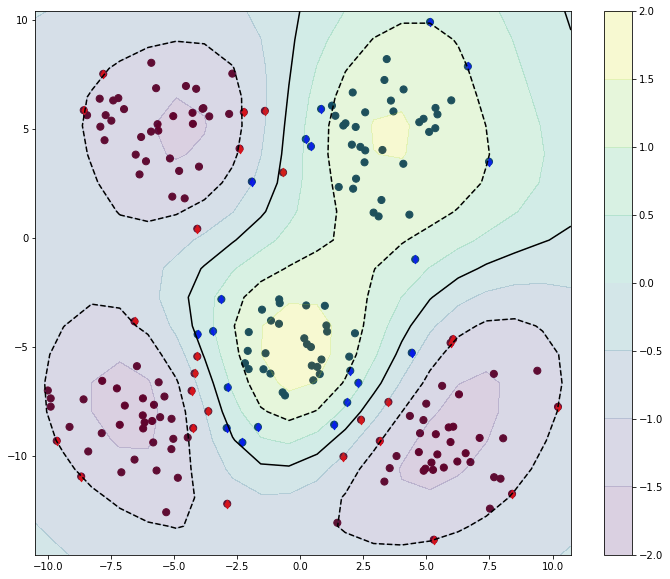

In [33]:
def plot_binary_problem(XX, YY, aa):
    aa.scatter(XX[:, 0], XX[:, 1], c=YY, s=50, cmap='RdBu')
def plot_svm_classifier(xc,yc,svm,ax):
    # generate a grid of points to evaluate classifier
    xmin = np.min(xc[:,0])
    xmax = np.max(xc[:,0])
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   20) # or whatever values for x
    ymin = np.min(xc[:,1])
    ymax = np.max(xc[:,1])
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   20)   # or whatever values for y
    
    X, Y = np.meshgrid(Xg, Yg)
    Xshape = X.shape
    Z = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    zz = svm.decision_function(Z)
    zz = zz.reshape(Xshape)
    ax.contour(X, Y, zz, [0], colors='black')
    ax.contour(X, Y, zz, [-1,1], linestyles='--', colors='black')
    id_svs = svm.support_
    positive_samples = np.where(yc==1)[0]
    negative_samples = np.where(yc==-1)[0]
    positive_support_vectors = np.intersect1d(id_svs, positive_samples)
    negative_support_vectors = np.intersect1d(id_svs, negative_samples)
    ax.scatter(xc[positive_support_vectors,0], xc[positive_support_vectors,1], marker='d',color='blue')
    ax.scatter(xc[negative_support_vectors,0], xc[negative_support_vectors,1], marker='d',color='red')
    
    return ax.contourf(X, Y, zz, alpha=0.2)


gamma = 0.05
C=1
model = svm.SVC(C=C,kernel='rbf', gamma=gamma)
model.fit(XX,YY)

ff,aa = plt.subplots(1,1, figsize=(12,10))
plot_binary_problem(XX, YY, aa)


cs = plot_svm_classifier(XX,YY,model,aa)

_ = ff.colorbar(cs, ax=aa)

Probemos diferentes combinaciones de $C$ y $\gamma$

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.


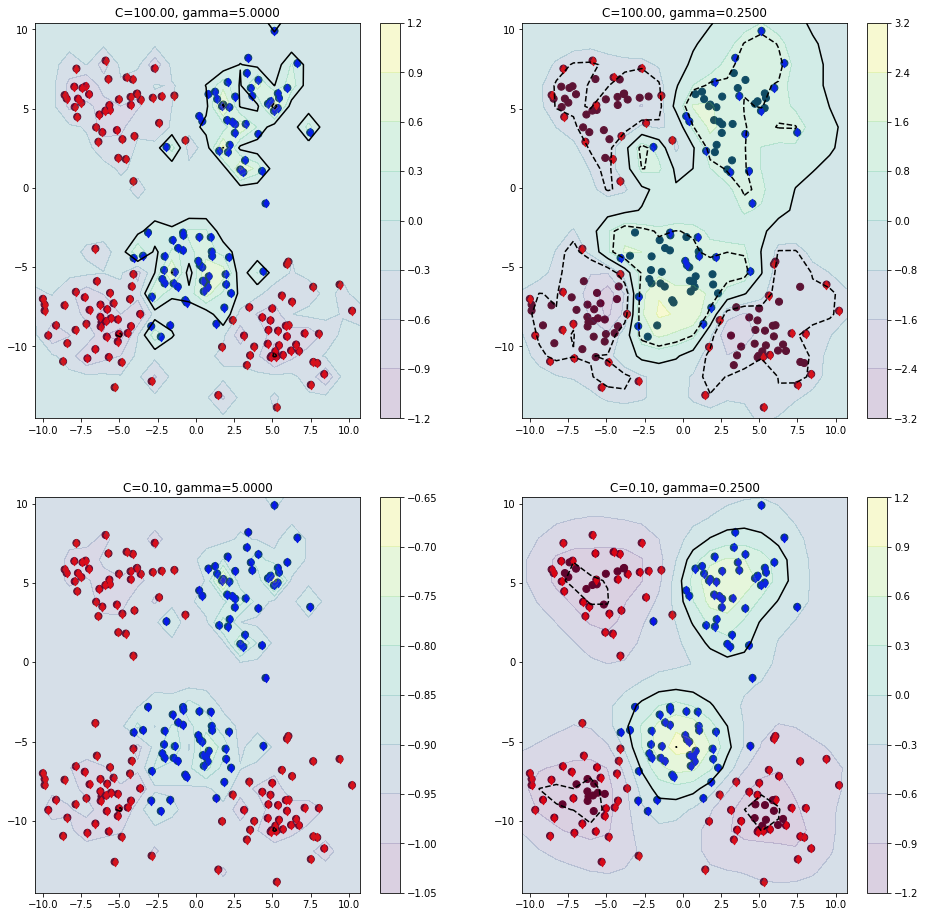

In [34]:
vC = [100,0.1]
vg = [5,0.25]
ff,aa = plt.subplots(2,2, figsize=(16,16))
for cc in range(2):
    C = vC[cc]
    for gg in range(2):
        ax = aa[cc][gg]
        gamma = vg[gg]
        model = svm.SVC(C=C,kernel='rbf', gamma=gamma)
        model.fit(XX,YY)
        plot_binary_problem(XX, YY, ax)
        cs = plot_svm_classifier(XX,YY,model,ax)
        _ = ff.colorbar(cs, ax=ax)
        ax.set_title('C={0:.2f}, gamma={1:.4f}'.format(C,gamma))

# 8. Efecto de la regularización

La figura de abajo muestra cómo cambia la suavidad de la frontera de clasificación a medida que variamos el peso de la regularización para una SVM trabajando sobre el mismo problema y con el mismo *kernel*.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.


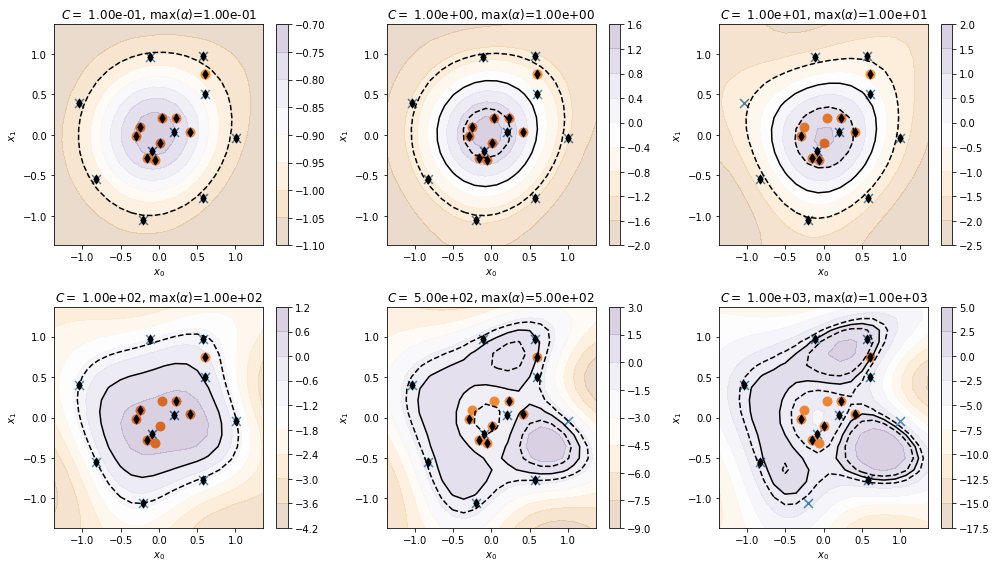

In [35]:
xk = np.vstack((xc, np.array([[0.2,0.03],[-0.09,-0.2],[.6, 0.75],[0.6, 0.5]])))
yk = np.hstack((yc,np.array([-1., -1., 1. , -1.])))

ff,ax = plt.subplots(2,3, figsize=(14,8))
"""
aa=ax[0][0]
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
"""
list_aa = [ax[0][0],ax[0][1], ax[0][2], ax[1][0], ax[1][1], ax[1][2]]


v_C = [0.1,1,10, 100, 500, 1000]
for ii, C in enumerate(v_C):
  model = svm.SVC(C=C,kernel='rbf', gamma=0.8)
  model.fit(xk,yk)
  akkyk = model.dual_coef_.T 
  bkk = model.intercept_
  aa=list_aa[ii]
  aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
  aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
  aa.set_xlabel('$x_0$')
  aa.set_ylabel('$x_1$')  
  cs = plot_kernel_classifier(-1.3, 1.3, -1.3, 1.3,model.support_vectors_,1,akkyk,aa,bkk,True)
  aa.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1], marker='d', s=40, color='black',
             label='SVs' )
  _ = ff.colorbar(cs, ax=aa)
  aa.set_title('$C=$ {0:.2e}, max($\\alpha$)={1:.2e}'.format(C, np.max(np.absolute(akkyk)))) 
ff.tight_layout()

# 9. Intuiciones sobre la influencia del kernel en la SVM

## Kernel RBF 

- El kernel RBF captura simetrías radiales. Todas las observaciones que se encuentren a la misma distancia  Euclídea de un vector soporte concreto reciven la misma activación de la función kernel que se coloca centrada en este vector soporte.

- La misma distancia radial en el espacio de entrada implica el mismo ángulo en el espacio de características, ya que los kernels en el espacio de entrada equivalen a productos escalares in el espacio de características.

### Dependencia de la función de clasificación con el valor de $\gamma$

En la figura de abajo representamos cómo varían las forma de los kernel RBF con el valor del hiperparámetro $\gamma$ (fila de arriba), cómo varía la activación que produce ese kernel en un vector soporte concreto (fila del centro) y cómo cambia la función de clasificación al combinar las activaciones de todos los vectores soporte (fila de abajo).

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.


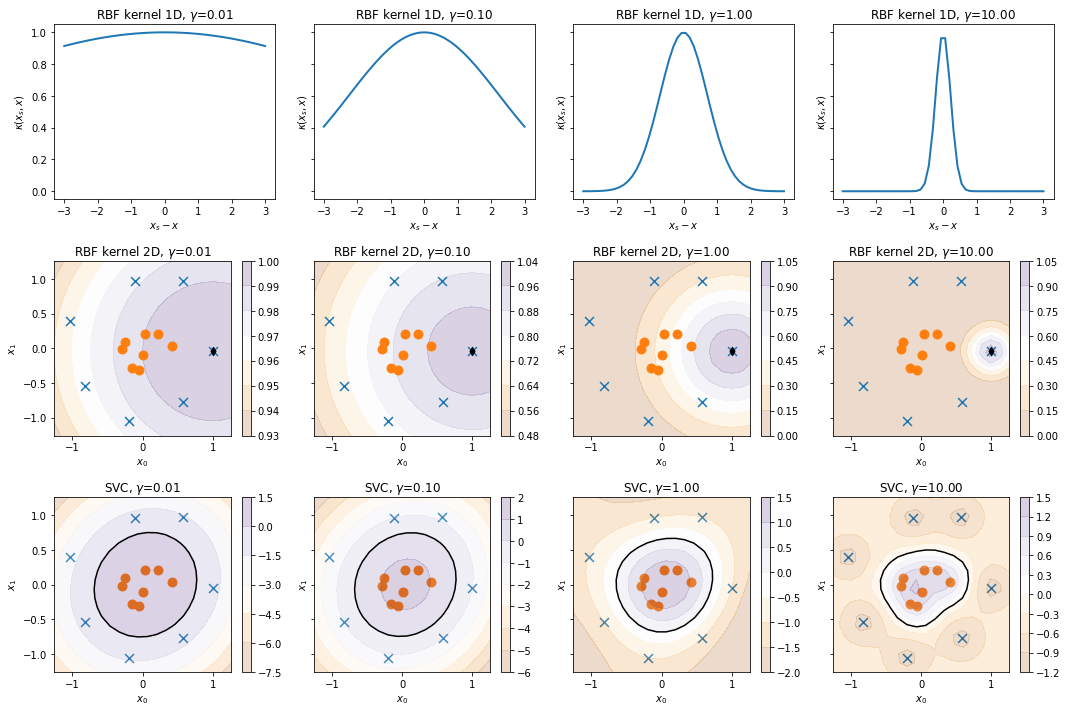

In [36]:
from sklearn.datasets.samples_generator import make_circles
from sklearn import svm
nc = 15
xc, yc = make_circles(nc, factor=0.3, noise=.1, random_state=42)
yc[yc==0]=-1
v_g = [0.01,.1,1,10]
C=1e10
ff, aa = plt.subplots(3,4,sharex='row', sharey='row',figsize=(15,10))
xx=np.linspace(-3,3)
for jj, gamma in enumerate(v_g):
  ax = aa[0][jj]
  ax.plot(xx, np.exp(-gamma*(xx)**2), linewidth=2)
  ax.set_xlabel('$x_s- x$')
  ax.set_ylabel('$\\kappa( x_s, x)$')
  ax.set_title('RBF kernel 1D, $\\gamma$={0:.2f}'.format(gamma))
 
  model = svm.SVC(C=C,kernel='rbf', gamma=gamma)
  model.fit(xc,yc)
  accyc = model.dual_coef_.T 
  bcc = model.intercept_

  ax = aa[1][jj]
  cs = plot_kernel_classifier(-1.2, 1.2, -1.2, 1.2, 
                              model.support_vectors_[0,:].reshape(1,-1),
                              gamma,1,ax,0,True,contr= False)
  _ = ff.colorbar(cs, ax=ax)
  ax.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
  ax.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
  ax.scatter(model.support_vectors_[0,0], model.support_vectors_[0,1],marker='d', color='black', label='SVs')
  ax.set_xlabel('$x_0$')
  ax.set_ylabel('$x_1$')
  ax.set_title('RBF kernel 2D, $\\gamma$={0:.2f}'.format(gamma))
  
  ax = aa[2][jj]
  ax.scatter(xc[yc==-1,0], xc[yc==-1,1], marker='x', s=80, label='train - class' )
  ax.scatter(xc[yc==1,0], xc[yc==1,1], marker='o', s=80, label='train + class' )
  cs = plot_kernel_classifier(-1.2, 1.2, -1.2, 1.2, 
                              model.support_vectors_,
                              gamma,accyc,ax,bcc,False,contr= True)
  _ = ff.colorbar(cs, ax=ax)
  ax.set_xlabel('$x_0$')
  ax.set_ylabel('$x_1$')
  ax.set_title('SVC, $\\gamma$={0:.2f}'.format(gamma))
ff.tight_layout()

